In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/AudioProcessing/Emotion_Recognition'
%ls

/content/drive/My Drive/AudioProcessing/Emotion_Recognition
 CREMA/     kaggle.json            RAVDESS_copied/                     try/
 EMODB/     model.png              SAVEE/
 EMO_DB/   'Papers & Materials'@   speech-emotion-recognition-en.zip
 IEMOCAP/   RAVDESS/               TESS/


In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.preprocessing import  StandardScaler
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
import csv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import keras

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 64000, 1) (3430, 4)
Test Data (735, 64000, 1) (735, 4)
Val Data (735, 64000, 1) (735, 4)


In [ ]:
csvpath = 'CREMA/hand_engineered_features_CREMA_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(3430, 26) (3430, 1)
(735, 26) (735, 1)
(735, 26) (735, 1)


# Crema Download

In [ ]:
! pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

 99% 982M/987M [00:10<00:00, 123MB/s]
100% 987M/987M [00:10<00:00, 99.4MB/s]


In [ ]:
import zipfile
path_to_zip_file = "speech-emotion-recognition-en.zip"
directory_to_extract_to = "try"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Crema Processing

In [ ]:
def decompose_crema():

        PATH = 'CREMA/Crema/'
        emotion = []
        path = []
        for dirname, _, filenames in os.walk(PATH):
          for name in filenames[1:]:
                    #print(name,len(name),name[6:8], dirname)
                    e = name.split('_')[2]
                
                    if e == 'SAD':  
                        emotion.append('sad')
                    elif e == 'ANG':  
                        emotion.append('angry')
                    elif e == 'DIS':  
                        emotion.append('disgust')
                    elif e == 'FEA':  
                        emotion.append('fear')
                    elif e == 'HAP':  
                        emotion.append('happy')
                    elif e == 'NEU':  
                        emotion.append('neutral')
                    
                    else:
                        print(name)
                        #emotion.append('m_neutral')
                

                    path.append(os.path.join(dirname,name))

        print(len(path),len(emotion))
        crema_df = pd.DataFrame(emotion, columns=['labels'])
        #emodb_df['source'] = 'EMODB'
        crema_df = pd.concat([crema_df, pd.DataFrame(path, columns=['path'])], axis=1)
        
        return crema_df

df = decompose_crema()
print(df.shape)
df.to_csv('CREMA/CREMA_details.csv',index=False,index_label=False)

7441 7441
(7441, 2)


In [ ]:
print(len(os.listdir('Crema')))
os.remove('Crema/crema_details.csv')
print(len(os.listdir('Crema')))

7443
7442


In [ ]:
df.head()

,labels,path
0,happy,CREMA/Crema/1079_TIE_HAP_XX.wav
1,neutral,CREMA/Crema/1079_TIE_NEU_XX.wav
2,sad,CREMA/Crema/1079_TIE_SAD_XX.wav
3,angry,CREMA/Crema/1079_TSI_ANG_XX.wav
4,disgust,CREMA/Crema/1079_TSI_DIS_XX.wav


In [ ]:
#angry, happy, neutral, sad
X = pd.read_csv('CREMA/CREMA_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 
  
rslt_df = X[X['labels'].isin(options)] 
print(np.unique(rslt_df.labels))
print(rslt_df.shape)
rslt_df.head()

['angry' 'happy' 'neutral' 'sad']
(4900, 2)


,labels,path
0,happy,CREMA/Crema/1079_TIE_HAP_XX.wav
1,neutral,CREMA/Crema/1079_TIE_NEU_XX.wav
2,sad,CREMA/Crema/1079_TIE_SAD_XX.wav
3,angry,CREMA/Crema/1079_TSI_ANG_XX.wav
6,happy,CREMA/Crema/1079_TSI_HAP_XX.wav


In [ ]:
test_val= rslt_df.sample(frac = 0.3)
train = rslt_df.drop(test_val.index)

test= test_val.sample(frac = 0.5)
val = test_val.drop(test.index)

In [ ]:
print(val['labels'].unique())
print(test['labels'].unique())
print(train['labels'].unique())

['angry' 'sad' 'happy' 'neutral']
['neutral' 'happy' 'sad' 'angry']
['neutral' 'sad' 'angry' 'happy']


In [ ]:
train.to_csv("CREMA//train.csv")
test.to_csv("CREMA//test.csv")
val.to_csv("CREMA//val.csv")

In [ ]:
sizes = []
for index, row in rslt_df.iterrows(): 
    #print(row['labels'],row['path'])
    y, sr = librosa.load(row['path'], mono=True, duration=30)
    sizes.append(y.shape[0])
    
print('The max size is',max(sizes))
print('The average size is ', sum(sizes)/len(sizes))
print(sr)

The max size is 110361
The average size is  54899.78265306122
22050


In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 5
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "CREMA//train.csv"
test_csv = "CREMA//test.csv"
val_csv = "CREMA//val.csv"
csvpath = 'CREMA//hand_engineered_features_CREMA_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'CREMA//hand_engineered_features_CREMA_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'CREMA//hand_engineered_features_CREMA_val.csv'
extract_features(csvpath,val_csv)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


# Wavenet Paper

In [ ]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(4)] * 2 
sr = 16000
time = 4
# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(int(sr*time), 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))
out = AveragePooling1D(sr*time)(out)
out = Conv1D(8,1,activation='relu')(out)
out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet_paper = Model(history_seq, out)
Wavenet_paper.summary()

Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 16)    32          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 32)    1056        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 64000, 32)    1056        ['conv1d[0][0]']                 
                                                                                              

## Trial 1

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//wavenet_paper_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//wavenet_paper_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet_paper.fit(X_train,Y_train, batch_size=16,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - 163s 592ms/step - loss: 1.3445 - accuracy: 0.7454 - val_loss: 1.0668 - val_accuracy: 0.7714

Epoch 00001: val_loss improved from inf to 1.06676, saving model to CREMA//models/wavenet_paper_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.77143, saving model to CREMA//models/wavenet_paper_acc.h5
Epoch 2/30
215/215 [==============================] - 128s 594ms/step - loss: 0.9989 - accuracy: 0.7971 - val_loss: 0.9596 - val_accuracy: 0.8017

Epoch 00002: val_loss improved from 1.06676 to 0.95956, saving model to CREMA//models/wavenet_paper_loss.h5

Epoch 00002: val_accuracy improved from 0.77143 to 0.80170, saving model to CREMA//models/wavenet_paper_acc.h5
Epoch 3/30
215/215 [==============================] - 128s 593ms/step - loss: 0.9522 - accuracy: 0.8056 - val_loss: 0.9547 - val_accuracy: 0.8020

Epoch 00003: val_loss improved from 0.95956 to 0.95473, saving model to CREMA//models/wavenet_paper_loss.h5

Epoch 00003: val_

In [ ]:
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

23/23 [==============================] - 11s 438ms/step - loss: 0.9177 - accuracy: 0.7942
[0.9206496477127075, 0.7962585091590881]
23/23 [==============================] - 10s 430ms/step - loss: 0.9206 - accuracy: 0.7963


[0.9206496477127075, 0.7962585091590881]

F1 SCORE: 0.6095894985652488
Kappa: 0.47411402461289454
Accuracy: 0.6054421768707483
Jaccard Score: 0.4442652151576233
Precision: 0.6125997308737743
Recall: 0.6105810404405541
              precision    recall  f1-score   support

           0       0.71      0.66      0.69       176
           1       0.53      0.47      0.50       204
           2       0.50      0.61      0.55       176
           3       0.70      0.70      0.70       179

    accuracy                           0.61       735
   macro avg       0.61      0.61      0.61       735
weighted avg       0.61      0.61      0.61       735



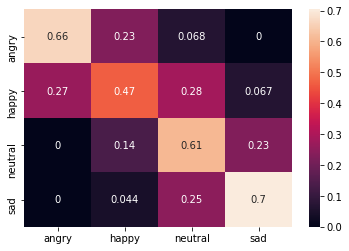

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//wavenet_paper_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//wavenet_paper_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet_paper.fit(X_train,Y_train, batch_size=16,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - ETA: 0s - loss: 1.3850 - accuracy: 0.7500
Epoch 1: val_loss improved from inf to 1.37674, saving model to CREMA//models/wavenet_paper_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to CREMA//models/wavenet_paper_acc_2.h5
215/215 [==============================] - 148s 599ms/step - loss: 1.3850 - accuracy: 0.7500 - val_loss: 1.3767 - val_accuracy: 0.7500
Epoch 2/30
215/215 [==============================] - ETA: 0s - loss: 1.2040 - accuracy: 0.7695
Epoch 2: val_loss improved from 1.37674 to 1.09981, saving model to CREMA//models/wavenet_paper_loss_2.h5

Epoch 2: val_accuracy improved from 0.75000 to 0.78810, saving model to CREMA//models/wavenet_paper_acc_2.h5
215/215 [==============================] - 132s 614ms/step - loss: 1.2040 - accuracy: 0.7695 - val_loss: 1.0998 - val_accuracy: 0.7881
Epoch 3/30
215/215 [==============================] - ETA: 0s - loss: 1.0447 - accuracy: 0.7979
Epoch 3: val_loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


F1 SCORE: 0.5225598392638751
Kappa: 0.40395355527339094
Accuracy: 0.5551020408163265
Jaccard Score: 0.37388958097725317
Precision: 0.5623506024045948
Recall: 0.5545522075005725
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       176
           1       0.45      0.54      0.49       204
           2       0.54      0.15      0.23       176
           3       0.56      0.83      0.67       179

    accuracy                           0.56       735
   macro avg       0.56      0.55      0.52       735
weighted avg       0.56      0.56      0.52       735



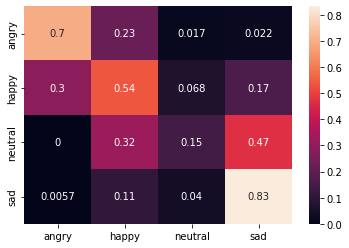

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

In [ ]:
Wavenet_paper.save_weights('CREMA//models//wavenet_paper_2.h5')

## Trial 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.5261110024731053
Kappa: 0.4050571810485667
Accuracy: 0.5551020408163265
Jaccard Score: 0.3745784163303434
Precision: 0.5547491039426523
Recall: 0.5560643092940579
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       176
           1       0.47      0.50      0.49       204
           2       0.52      0.18      0.26       176
           3       0.54      0.84      0.66       179

    accuracy                           0.56       735
   macro avg       0.55      0.56      0.53       735
weighted avg       0.55      0.56      0.53       735



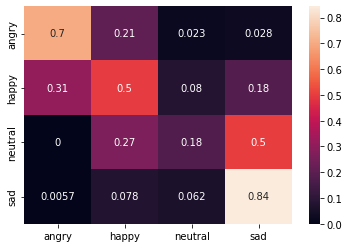

In [ ]:
#test set
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_loss_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.5261110024731053
Kappa: 0.4050571810485667
Accuracy: 0.5551020408163265
Jaccard Score: 0.3745784163303434
Precision: 0.5547491039426523
Recall: 0.5560643092940579
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       176
           1       0.47      0.50      0.49       204
           2       0.52      0.18      0.26       176
           3       0.54      0.84      0.66       179

    accuracy                           0.56       735
   macro avg       0.55      0.56      0.53       735
weighted avg       0.55      0.56      0.53       735



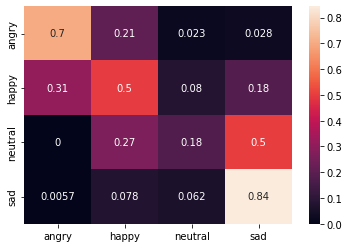

In [ ]:
#test set
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_acc_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Wavenet 5

In [ ]:
# hyper-parameters

def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention

n_filters = 64
filter_width = 2
dilation_rates = [2**i for i in range(3)]  
sr = 16000

history_seq = Input(shape=(int(sr*time), 1))
x = history_seq



x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)
skips = []
for dilation_rate in dilation_rates:
    
    
    x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    
    skips.append(z)


out = Activation('relu')(Add()(skips))

out = AveragePooling1D(8000)(out)
out = self_attention(out)

out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet5 = Model(history_seq, out)
Wavenet5.summary()

Wavenet5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 64000, 8)     48          input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 64000, 8)     0           conv1d_56[0][0]                  
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 64000, 8)     328         leaky_re_lu_8[0][0]              
____________________________________________________________________________________________

In [ ]:
Wavenet5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//wavenet5_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//wavenet5_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet5.fit(X_train,Y_train, batch_size=16,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - 26s 109ms/step - loss: 1.2313 - accuracy: 0.7663 - val_loss: 1.0175 - val_accuracy: 0.7935

Epoch 00001: val_loss improved from inf to 1.01748, saving model to CREMA//models/wavenet5_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.79354, saving model to CREMA//models/wavenet5_acc.h5
Epoch 2/30
215/215 [==============================] - 23s 105ms/step - loss: 0.9873 - accuracy: 0.7959 - val_loss: 1.0373 - val_accuracy: 0.7956

Epoch 00002: val_loss did not improve from 1.01748

Epoch 00002: val_accuracy improved from 0.79354 to 0.79558, saving model to CREMA//models/wavenet5_acc.h5
Epoch 3/30
215/215 [==============================] - 23s 106ms/step - loss: 0.9697 - accuracy: 0.7959 - val_loss: 1.0006 - val_accuracy: 0.8048

Epoch 00003: val_loss improved from 1.01748 to 1.00064, saving model to CREMA//models/wavenet5_loss.h5

Epoch 00003: val_accuracy improved from 0.79558 to 0.80476, saving model to CREMA//models/wavenet

In [ ]:
Wavenet5.load_weights('CREMA//models//wavenet5_loss.h5')
print(Wavenet5.evaluate(X_test,Y_test))
Wavenet5.load_weights('CREMA//models//wavenet5_acc.h5')
Wavenet5.evaluate(X_test,Y_test)

23/23 [==============================] - 3s 82ms/step - loss: 0.9171 - accuracy: 0.8126
[0.9033066034317017, 0.8122448921203613]
23/23 [==============================] - 2s 80ms/step - loss: 0.9090 - accuracy: 0.8088


[0.9090140461921692, 0.8088435530662537]

23/23 [==============================] - 2s 82ms/step - loss: 0.9090 - accuracy: 0.8088
(735,) (735,)
F1 SCORE: 0.5924334307056143
Kappa: 0.4480874316939891
Accuracy: 0.5877551020408164
Jaccard Score: 0.4253361940153305
Precision: 0.6035985951835625
Recall: 0.587678564315518


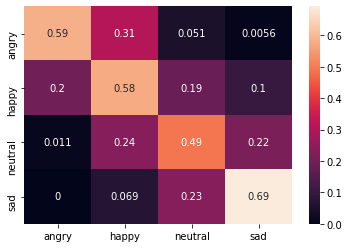

In [ ]:
Wavenet5.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet5.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet5.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Ann

In [ ]:
ann_model = Sequential(name='Input_Layer')
ann_model.add(Dense(128,name='Dense_1'))
ann_model.add(LeakyReLU(name='Leaky_Relu_Activation_1'))
ann_model.add(Dense(32,name='Dense_2'))
ann_model.add(LeakyReLU(name = 'LEaky_Relu_Activation_2'))
ann_model.add(Dense(4, activation='softmax',name='Output_Layer'))

ann_model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann_model.fit(X_train_features,
          Y_train_features,
          epochs=1,
          batch_size=16,
          validation_data=(X_val_features, Y_val_features))

215/215 [==============================] - 1s 3ms/step - loss: 1.0678 - accuracy: 0.5267 - val_loss: 0.8684 - val_accuracy: 0.6381


In [ ]:
ann_model = Sequential(name='Input_Layer')
ann_model.add(Dense(128,name='Dense_1',kernel_initializer=keras.initializers.VarianceScaling()))
ann_model.add(LeakyReLU(name='Leaky_Relu_Activation_1'))

ann_model.add(Dense(32,name='Dense_3',kernel_initializer=keras.initializers.VarianceScaling()))
ann_model.add(ReLU(name = 'Relu_Activation_3'))
ann_model.add(Dense(4, activation='softmax',name='Output_Layer'))

ann_model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_checkpoint1 = ModelCheckpoint('CREMA//models//ANN_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//ANN_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ann_model.fit(X_train_features,
          Y_train_features,
          epochs=30,
          batch_size=16,
          validation_data=(X_val_features, Y_val_features),callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - 1s 3ms/step - loss: 1.0802 - accuracy: 0.4860 - val_loss: 0.9365 - val_accuracy: 0.5932

Epoch 00001: val_loss improved from inf to 0.93650, saving model to CREMA//models/ANN_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.59320, saving model to CREMA//models/ANN_acc.h5
Epoch 2/30
215/215 [==============================] - 1s 2ms/step - loss: 0.8450 - accuracy: 0.6174 - val_loss: 0.9045 - val_accuracy: 0.6109

Epoch 00002: val_loss improved from 0.93650 to 0.90445, saving model to CREMA//models/ANN_loss.h5

Epoch 00002: val_accuracy improved from 0.59320 to 0.61088, saving model to CREMA//models/ANN_acc.h5
Epoch 3/30
215/215 [==============================] - 1s 2ms/step - loss: 0.7980 - accuracy: 0.6682 - val_loss: 0.8843 - val_accuracy: 0.6136

Epoch 00003: val_loss improved from 0.90445 to 0.88426, saving model to CREMA//models/ANN_loss.h5

Epoch 00003: val_accuracy improved from 0.61088 to 0.61361, saving model to CRE

In [ ]:
ann_model.load_weights('CREMA//models//ANN_loss.h5')
print(ann_model.evaluate(X_test_features,Y_test_features))
ann_model.load_weights('CREMA//models//ANN_acc.h5')
ann_model.evaluate(X_test_features,Y_test_features)

23/23 [==============================] - 0s 2ms/step - loss: 0.7347 - accuracy: 0.6857
[0.7347415685653687, 0.6857143044471741]
23/23 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.7184


[0.6797551512718201, 0.718367338180542]

23/23 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.7184
[0.6797551512718201, 0.718367338180542]
F1 SCORE: 0.7183630478183216
Kappa: 0.6248011738449587
Accuracy: 0.7183673469387755
Jaccard Score: 0.5636046540833113
Precision: 0.718303439873059
Recall: 0.7230094964598334


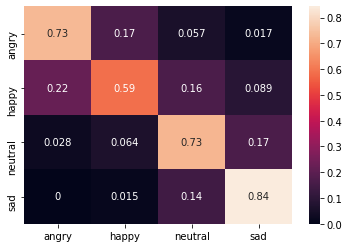

In [ ]:
print(ann_model.evaluate(X_test_features,Y_test_features))
g = Y_test_features
p = np.argmax(ann_model.predict(X_test_features),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(ann_model.predict(X_test_features),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# ensembled

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 64000, 8)     48          ['input_7[0][0]']                
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 64000, 8)     0           ['conv1d_21[0][0]']              
                                                                                                  
 conv1d_22 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_8[0][0]']          
                                                                                            

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//ensembled_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//ensembled_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - 24s 102ms/step - loss: 1.0713 - accuracy: 0.4836 - val_loss: 0.9337 - val_accuracy: 0.5864

Epoch 00001: val_loss improved from inf to 0.93372, saving model to CREMA//models/ensembled_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.58639, saving model to CREMA//models/ensembled_acc.h5
Epoch 2/30
215/215 [==============================] - 22s 102ms/step - loss: 0.8573 - accuracy: 0.6183 - val_loss: 0.8960 - val_accuracy: 0.6204

Epoch 00002: val_loss improved from 0.93372 to 0.89603, saving model to CREMA//models/ensembled_loss.h5

Epoch 00002: val_accuracy improved from 0.58639 to 0.62041, saving model to CREMA//models/ensembled_acc.h5
Epoch 3/30
215/215 [==============================] - 22s 103ms/step - loss: 0.8228 - accuracy: 0.6406 - val_loss: 0.8861 - val_accuracy: 0.6095

Epoch 00003: val_loss improved from 0.89603 to 0.88607, saving model to CREMA//models/ensembled_loss.h5

Epoch 00003: val_accuracy did not improv

In [ ]:
ensembled.load_weights("CREMA//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("CREMA//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

23/23 [==============================] - 3s 82ms/step - loss: 0.6697 - accuracy: 0.7198
[0.6857007145881653, 0.7102040648460388]
23/23 [==============================] - 2s 81ms/step - loss: 0.6271 - accuracy: 0.7415


[0.62712162733078, 0.7414966225624084]

23/23 [==============================] - 2s 82ms/step - loss: 0.6271 - accuracy: 0.7415
[0.62712162733078, 0.7414966225624084]
F1 SCORE: 0.743124202132549
Kappa: 0.6553477249001088
Accuracy: 0.7414965986394558
Jaccard Score: 0.5938238380238596
Precision: 0.7428832137899528
Recall: 0.7452268743962795


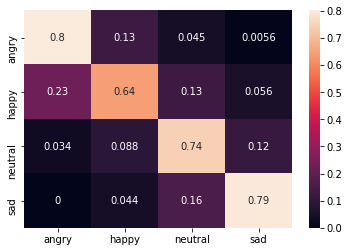

In [ ]:

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## trial 2

23/23 [==============================] - 8s 181ms/step - loss: 0.6857 - accuracy: 0.7102
[0.6857007741928101, 0.7102040648460388]
F1 SCORE: 0.7118108024531272
Kappa: 0.6133403804974672
Accuracy: 0.710204081632653
Jaccard Score: 0.5558969706343886
Precision: 0.7108732539466109
Recall: 0.7134360155946584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


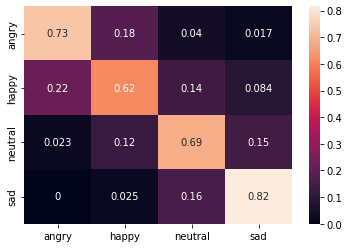

In [ ]:
ensembled.load_weights("CREMA//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## trial 3

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//ensembled_loss_3.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//ensembled_acc_3.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.5414
Epoch 1: val_loss improved from inf to 0.88805, saving model to CREMA//models/ensembled_loss_3.h5

Epoch 1: val_accuracy improved from -inf to 0.59456, saving model to CREMA//models/ensembled_acc_3.h5
215/215 [==============================] - 59s 239ms/step - loss: 0.9835 - accuracy: 0.5414 - val_loss: 0.8880 - val_accuracy: 0.5946
Epoch 2/30
215/215 [==============================] - ETA: 0s - loss: 0.8660 - accuracy: 0.6172
Epoch 2: val_loss improved from 0.88805 to 0.84863, saving model to CREMA//models/ensembled_loss_3.h5

Epoch 2: val_accuracy improved from 0.59456 to 0.62585, saving model to CREMA//models/ensembled_acc_3.h5
215/215 [==============================] - 50s 231ms/step - loss: 0.8660 - accuracy: 0.6172 - val_loss: 0.8486 - val_accuracy: 0.6259
Epoch 3/30
215/215 [==============================] - ETA: 0s - loss: 0.8306 - accuracy: 0.6353
Epoch 3: val_loss improved from 0.8

23/23 [==============================] - 4s 166ms/step - loss: 0.7948 - accuracy: 0.6476
[0.7948029041290283, 0.6476190686225891]
F1 SCORE: 0.6441569729222882
Kappa: 0.5302111970464989
Accuracy: 0.6476190476190476
Jaccard Score: 0.48063293555357045
Precision: 0.6441729988871778
Recall: 0.6515330452902339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


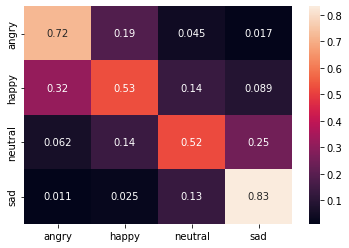

In [ ]:
ensembled.load_weights("CREMA//models//ensembled_loss_3.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## trial 4

23/23 [==============================] - 4s 162ms/step - loss: 0.8015 - accuracy: 0.6558
[0.8015031218528748, 0.6557823419570923]
F1 SCORE: 0.6537426550223359
Kappa: 0.5412901745739257
Accuracy: 0.6557823129251701
Jaccard Score: 0.4910104501742776
Precision: 0.6527583674434134
Recall: 0.6607596981148985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


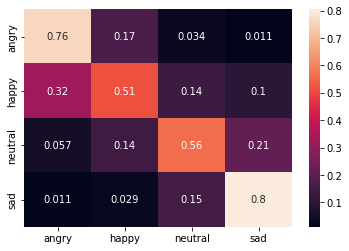

In [ ]:
ensembled.load_weights("CREMA//models//ensembled_acc_3.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# ensembled new

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)


  out = Conv1D(4,1,activation='softmax')(out)
  out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  out2 = Dense(4,activation = 'softmax')(layer3)
  out2 = Reshape((4,1))(out2)

  output_layer = Average()([out1,out2])
  
  
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_new = Wavenet()
ensembled_new.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 64000, 8)     48          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64000, 8)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64000, 8)     328         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [ ]:
ensembled_new.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//ensembled_new_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//ensembled_new_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_new.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - 57s 105ms/step - loss: 1.1127 - accuracy: 0.7878 - val_loss: 0.9018 - val_accuracy: 0.8126

Epoch 00001: val_loss improved from inf to 0.90185, saving model to CREMA//models/ensembled_new_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.81259, saving model to CREMA//models/ensembled_new_acc.h5
Epoch 2/30
215/215 [==============================] - 22s 100ms/step - loss: 0.8884 - accuracy: 0.8199 - val_loss: 0.8755 - val_accuracy: 0.8221

Epoch 00002: val_loss improved from 0.90185 to 0.87547, saving model to CREMA//models/ensembled_new_loss.h5

Epoch 00002: val_accuracy improved from 0.81259 to 0.82211, saving model to CREMA//models/ensembled_new_acc.h5
Epoch 3/30
215/215 [==============================] - 22s 101ms/step - loss: 0.8462 - accuracy: 0.8247 - val_loss: 0.8418 - val_accuracy: 0.8180

Epoch 00003: val_loss improved from 0.87547 to 0.84178, saving model to CREMA//models/ensembled_new_loss.h5

Epoch 00003: val_acc

In [ ]:

ensembled_new.load_weights("CREMA//models/ensembled_new_loss.h5")
print(ensembled_new.evaluate([X_test,X_test_features],Y_test))

ensembled_new.load_weights("CREMA//models/ensembled_new_acc.h5")
ensembled_new.evaluate([X_test,X_test_features],Y_test)

23/23 [==============================] - 2s 86ms/step - loss: 0.8212 - accuracy: 0.8272
[0.8212383985519409, 0.8272109031677246]
23/23 [==============================] - 2s 77ms/step - loss: 0.8104 - accuracy: 0.8367


[0.8103684782981873, 0.8367347121238708]

23/23 [==============================] - 2s 78ms/step - loss: 0.8104 - accuracy: 0.8367
[0.8103684782981873, 0.8367347121238708]
F1 SCORE: 0.6551597133074494
Kappa: 0.5375681897247244
Accuracy: 0.6530612244897959
Jaccard Score: 0.4901073112711044
Precision: 0.6557266463453356
Recall: 0.6571299069399218


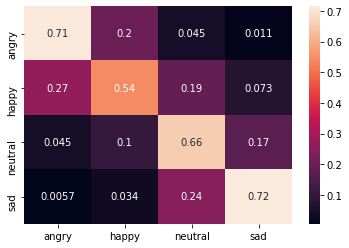

In [ ]:
#test set
print(ensembled_new.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)


  out = Conv1D(4,1,activation='softmax')(out)
  out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  out2 = Dense(4,activation = 'softmax')(layer3)
  out2 = Reshape((4,1))(out2)

  output_layer = Concatenate()([out1,out2])
  
  output_layer = Conv1D(4,1,activation = 'softmax')(output_layer)
  
  
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_new = Wavenet()
ensembled_new.summary()


# Paper_1

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
srk = 16000
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 64000, 1) (3430, 4)
Test Data (735, 64000, 1) (735, 4)
Val Data (735, 64000, 1) (735, 4)


In [ ]:
def paper_model():
  inp = Input((srk*time,1))
  l1 = BatchNormalization()(Conv1D(32,21,activation='relu',padding = 'same')(inp))
  m1 = MaxPool1D(2)(l1)

  l2 = BatchNormalization()(Conv1D(64,19,activation='relu',padding = 'same')(m1))
  m2 = MaxPool1D(2)(l2)

  l3 = BatchNormalization()(Conv1D(128,17,activation='relu',padding = 'same')(m2))
  m3 = MaxPool1D(2)(l3)


  l4 = BatchNormalization()(Conv1D(256,15,activation='relu',padding = 'same')(m3))
  m4 = MaxPool1D(2)(l4)

  l5 = BatchNormalization()(Conv1D(512,13,activation='relu',padding = 'same')(m4))
  m5 = MaxPool1D(2)(l5)

  l6 = BatchNormalization()(Conv1D(1024,11,activation='relu',padding = 'same')(m5))
  m6 = MaxPool1D(2)(l6)

  l7 = BatchNormalization()(Conv1D(1024,9,activation='relu',padding = 'same')(m6))
  m7 = GlobalMaxPool1D()(l7)

  fl = Flatten()(m7)
  d1 = Dense(128,activation='relu')(fl)
  out = Dense(4,activation='softmax')(d1)

  return Model(inputs = inp,outputs = out)

m = paper_model()
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 64000, 32)         704       
                                                                 
 batch_normalization_2 (Batc  (None, 64000, 32)        128       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32000, 32)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 32000, 64)         38976     
                                                                 
 batch_normalization_3 (Batc  (None, 32000, 64)        256 

In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_1_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_1_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = m.fit(X_train,Y_train, batch_size=12,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
286/286 [==============================] - 252s 748ms/step - loss: 1.9539 - accuracy: 0.4848 - val_loss: 2.3564 - val_accuracy: 0.3320

Epoch 00001: val_loss improved from inf to 2.35645, saving model to CREMA//models/paper_1_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.33197, saving model to CREMA//models/paper_1_acc.h5
Epoch 2/30
286/286 [==============================] - 215s 751ms/step - loss: 1.0518 - accuracy: 0.5602 - val_loss: 1.9656 - val_accuracy: 0.2531

Epoch 00002: val_loss improved from 2.35645 to 1.96557, saving model to CREMA//models/paper_1_loss.h5

Epoch 00002: val_accuracy did not improve from 0.33197
Epoch 3/30
286/286 [==============================] - 215s 751ms/step - loss: 0.9824 - accuracy: 0.5627 - val_loss: 0.9645 - val_accuracy: 0.5442

Epoch 00003: val_loss improved from 1.96557 to 0.96450, saving model to CREMA//models/paper_1_loss.h5

Epoch 00003: val_accuracy improved from 0.33197 to 0.54422, saving model to CREMA//models/paper_1

In [ ]:
m.load_weights('CREMA//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('CREMA//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

23/23 [==============================] - 15s 495ms/step - loss: 0.8532 - accuracy: 0.6150
[0.8531513214111328, 0.6149659752845764]
23/23 [==============================] - 7s 313ms/step - loss: 0.8532 - accuracy: 0.6150


[0.8531513214111328, 0.6149659752845764]

F1 SCORE: 0.6227927200076868
Kappa: 0.4856097850494099
Accuracy: 0.6149659863945578
Jaccard Score: 0.45616633448920174
Precision: 0.6377393608752892
Recall: 0.6171769971320169
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       176
           1       0.53      0.56      0.54       204
           2       0.51      0.62      0.56       176
           3       0.80      0.62      0.70       179

    accuracy                           0.61       735
   macro avg       0.64      0.62      0.62       735
weighted avg       0.63      0.61      0.62       735



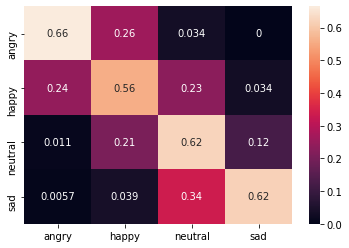

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_1_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_1_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = m.fit(X_train,Y_train, batch_size=48,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
108/108 [==============================] - ETA: 0s - loss: 1.1559 - accuracy: 0.5300
Epoch 1: val_loss improved from inf to 1.55573, saving model to CREMA//models/paper_1_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.33061, saving model to CREMA//models/paper_1_acc_2.h5
108/108 [==============================] - 182s 2s/step - loss: 1.1559 - accuracy: 0.5300 - val_loss: 1.5557 - val_accuracy: 0.3306
Epoch 2/30
 57/108 [==============>...............] - ETA: 1:13 - loss: 1.0217 - accuracy: 0.5592

KeyboardInterrupt: ignored

# Paper 2

In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('CREMA/CREMA_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]

max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (64, 501)


In [ ]:
max_x,max_y = (64,501)
T = 80
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

501 80 560 7


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "CREMA//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "CREMA//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "CREMA//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(3430, 7, 64, 80, 3) (3430, 4)
(735, 7, 64, 80, 3) (735, 4)
(735, 7, 64, 80, 3) (735, 4)


In [ ]:
import keras
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Reshape((36,256))(X)

    X= LSTM(256,return_sequences=True)(X)
    X= LSTM(256)(X)

    
    #X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    #X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    

    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    return model

def paper_2():
    input_layer = Input((int(max_y/T)+1,max_x,T,3))
    alex = AlexNet((227,227,3))
    
    for i in range(int(max_y/T)+1):
      #print(input_layer[:,0,:,:,:].shape)
      inp = Resizing(227,227)(input_layer[:,i,:,:,:])
      
      cnn = alex(inp)

      #cnn = Reshape((1,4096))(cnn)

      if i == 0:
        output_layers = cnn
      else:
        output_layers = Concatenate(axis = 1)([output_layers,cnn])
      
    
    #print(len(output_layers))
    #lstm = LSTM(256,return_sequences=True)(output_layers)
    #lstm = LSTM(256,return_sequences=True)(lstm)
    #lstm = LSTM(256)(lstm)
    
    out = Dense(4,activation='softmax')(output_layers)
    
    
    
    return Model(inputs=input_layer,outputs=out)
p2 = paper_2()
p2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 7, 64, 80,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_7 (Sl  (None, 64, 80, 3)   0           ['input_6[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_8 (Sl  (None, 64, 80, 3)   0           ['input_6[0][0]']                
 icingOpLambda)                                                                             

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_2_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_2_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p2.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - 77s 141ms/step - loss: 1.2164 - accuracy: 0.4464 - val_loss: 1.0434 - val_accuracy: 0.5510

Epoch 00001: val_loss improved from inf to 1.04340, saving model to CREMA//models/paper_2_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.55102, saving model to CREMA//models/paper_2_acc.h5
Epoch 2/30
429/429 [==============================] - 56s 131ms/step - loss: 1.0803 - accuracy: 0.5108 - val_loss: 1.4129 - val_accuracy: 0.4000

Epoch 00002: val_loss did not improve from 1.04340

Epoch 00002: val_accuracy did not improve from 0.55102
Epoch 3/30
429/429 [==============================] - 56s 131ms/step - loss: 1.0163 - accuracy: 0.5502 - val_loss: 1.1383 - val_accuracy: 0.5170

Epoch 00003: val_loss did not improve from 1.04340

Epoch 00003: val_accuracy did not improve from 0.55102
Epoch 4/30
429/429 [==============================] - 56s 131ms/step - loss: 1.0201 - accuracy: 0.5381 - val_loss: 0.9815 - val_accuracy: 0.5701

E

In [ ]:
p2.load_weights('CREMA//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('CREMA//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

23/23 [==============================] - 4s 128ms/step - loss: 0.9037 - accuracy: 0.5864
[0.9037154316902161, 0.5863945484161377]
23/23 [==============================] - 2s 101ms/step - loss: 0.8996 - accuracy: 0.5878


[0.8996180891990662, 0.5877550840377808]

F1 SCORE: 0.5812097738050113
Kappa: 0.44919446189460976
Accuracy: 0.5877551020408164
Jaccard Score: 0.42192204301075276
Precision: 0.5822869479985151
Recall: 0.5899126410340674
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       176
           1       0.49      0.50      0.50       204
           2       0.47      0.37      0.42       176
           3       0.67      0.85      0.75       179

    accuracy                           0.59       735
   macro avg       0.58      0.59      0.58       735
weighted avg       0.58      0.59      0.58       735



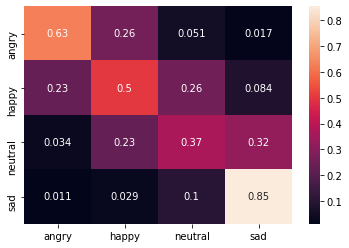

In [ ]:
#test set

from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.5839565386460527
Kappa: 0.44865160970337625
Accuracy: 0.5863945578231292
Jaccard Score: 0.4255550063797231
Precision: 0.5796402548741415
Recall: 0.5926012196397096
              precision    recall  f1-score   support

           0       0.64      0.76      0.70       176
           1       0.47      0.41      0.44       204
           2       0.49      0.44      0.46       176
           3       0.72      0.76      0.74       179

    accuracy                           0.59       735
   macro avg       0.58      0.59      0.58       735
weighted avg       0.58      0.59      0.58       735



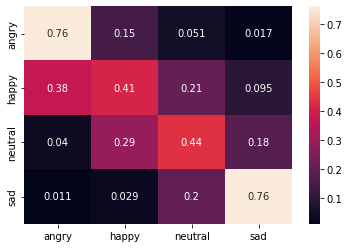

In [ ]:
#test set
p2.load_weights('CREMA//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 3

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_2_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_2_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p2.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - ETA: 0s - loss: 1.1516 - accuracy: 0.4735
Epoch 1: val_loss improved from inf to 1.82714, saving model to CREMA//models/paper_2_loss_2.h5

Epoch 1: val_accuracy improved from -inf to 0.26395, saving model to CREMA//models/paper_2_acc_2.h5
429/429 [==============================] - 101s 155ms/step - loss: 1.1516 - accuracy: 0.4735 - val_loss: 1.8271 - val_accuracy: 0.2639
Epoch 2/30
429/429 [==============================] - ETA: 0s - loss: 1.0765 - accuracy: 0.5277
Epoch 2: val_loss improved from 1.82714 to 1.18535, saving model to CREMA//models/paper_2_loss_2.h5

Epoch 2: val_accuracy improved from 0.26395 to 0.48435, saving model to CREMA//models/paper_2_acc_2.h5
429/429 [==============================] - 60s 140ms/step - loss: 1.0765 - accuracy: 0.5277 - val_loss: 1.1854 - val_accuracy: 0.4844
Epoch 3/30
429/429 [==============================] - ETA: 0s - loss: 1.0400 - accuracy: 0.5370
Epoch 3: val_loss improved from 1.18535 to

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.5958340356281338
Kappa: 0.4608695437414484
Accuracy: 0.5959183673469388
Jaccard Score: 0.43637540747984827
Precision: 0.5940114536179895
Recall: 0.6006423709656539
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       176
           1       0.48      0.46      0.47       204
           2       0.49      0.44      0.47       176
           3       0.76      0.75      0.75       179

    accuracy                           0.60       735
   macro avg       0.59      0.60      0.60       735
weighted avg       0.59      0.60      0.59       735



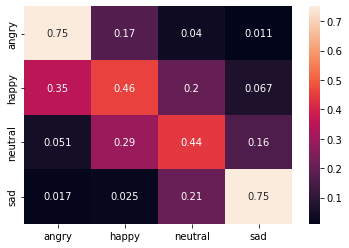

In [ ]:
#test set
#p2.load_weights('CREMA//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

In [ ]:
p2.save_weights('CREMA//models//paper_2_2.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.6224566412409481
Kappa: 0.4979000559820661
Accuracy: 0.6231292517006802
Jaccard Score: 0.46061860808072796
Precision: 0.6199651499618556
Recall: 0.6289845547157411
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       176
           1       0.55      0.46      0.50       204
           2       0.53      0.55      0.54       176
           3       0.70      0.81      0.75       179

    accuracy                           0.62       735
   macro avg       0.62      0.63      0.62       735
weighted avg       0.62      0.62      0.62       735



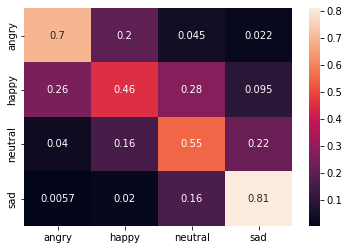

In [ ]:
#test set
p2.load_weights('CREMA//models//paper_2_acc_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.5826218722775003
Kappa: 0.46232094664729084
Accuracy: 0.5972789115646259
Jaccard Score: 0.426730735812235
Precision: 0.5836940836940837
Recall: 0.6004645224011392
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       176
           1       0.51      0.49      0.50       204
           2       0.50      0.31      0.38       176
           3       0.66      0.85      0.74       179

    accuracy                           0.60       735
   macro avg       0.58      0.60      0.58       735
weighted avg       0.58      0.60      0.58       735



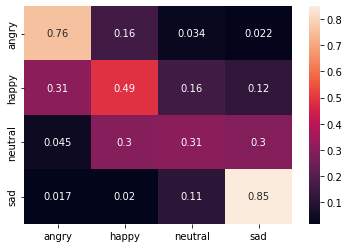

In [ ]:
#test set
p2.load_weights('CREMA//models//paper_2_loss_2.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

#Paper _3

In [ ]:
def paper_3():
  inp =  Input((time*16000,1))
  l1 = Conv1D(64,80,strides = 4,padding = 'same')(inp)
  m1 = MaxPooling1D(4)(l1)

  l2 = Conv1D(128,3,strides = 1,padding = 'same')(m1)
  l2 = Conv1D(128,3,strides = 1,padding = 'same')(l2)
  m2 = MaxPooling1D(4)(l2)

  l3 = Conv1D(256,3,strides = 1,padding = 'same')(m2)
  l3 = Conv1D(256,3,strides = 1,padding = 'same')(l3)
  m3 = MaxPooling1D(4)(l3)

  l4 = Conv1D(512,3,strides = 1,padding = 'same')(m3)
  l4 = Conv1D(512,3,strides = 1,padding = 'same')(l4)
  m4 = GlobalAveragePooling1D()(l4)

  f1 = Dense(1024)(m4)
  f2 = Dense(4, activation='softmax')(f1)

  return Model(inputs= inp,outputs=f2)

p3 = paper_3()
p3.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64000, 1)]        0         
                                                                 
 conv1d_7 (Conv1D)           (None, 16000, 64)         5184      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 4000, 64)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 4000, 128)         24704     
                                                                 
 conv1d_9 (Conv1D)           (None, 4000, 128)         49280     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1000, 128)        0         
 1D)                                                       

## Trial 1

In [ ]:
p3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_3_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_3_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p3.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - 14s 30ms/step - loss: 1.2232 - accuracy: 0.4255 - val_loss: 1.0595 - val_accuracy: 0.5510

Epoch 00001: val_loss improved from inf to 1.05946, saving model to CREMA//models/paper_3_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.55102, saving model to CREMA//models/paper_3_acc.h5
Epoch 2/30
429/429 [==============================] - 12s 29ms/step - loss: 1.1553 - accuracy: 0.4708 - val_loss: 1.0562 - val_accuracy: 0.5333

Epoch 00002: val_loss improved from 1.05946 to 1.05620, saving model to CREMA//models/paper_3_loss.h5

Epoch 00002: val_accuracy did not improve from 0.55102
Epoch 3/30
429/429 [==============================] - 12s 29ms/step - loss: 1.0345 - accuracy: 0.5352 - val_loss: 1.0997 - val_accuracy: 0.4476

Epoch 00003: val_loss did not improve from 1.05620

Epoch 00003: val_accuracy did not improve from 0.55102
Epoch 4/30
429/429 [==============================] - 12s 29ms/step - loss: 1.1303 - accuracy: 0.44

In [ ]:

p3.load_weights('CREMA//models//paper_3_acc.h5')
print(p3.evaluate(X_test,Y_test))
p3.load_weights('CREMA//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

23/23 [==============================] - 1s 48ms/step - loss: 0.9418 - accuracy: 0.5701
[0.9417681694030762, 0.5700680017471313]
23/23 [==============================] - 1s 38ms/step - loss: 0.9344 - accuracy: 0.5456


[0.9343971610069275, 0.5455782413482666]

F1 SCORE: 0.5543780282486602
Kappa: 0.4259543946891019
Accuracy: 0.5700680272108843
Jaccard Score: 0.3951475120085973
Precision: 0.5681924132353088
Recall: 0.5718604671426721
              precision    recall  f1-score   support

           0       0.71      0.66      0.69       176
           1       0.52      0.50      0.51       204
           2       0.49      0.28      0.36       176
           3       0.55      0.85      0.67       179

    accuracy                           0.57       735
   macro avg       0.57      0.57      0.55       735
weighted avg       0.57      0.57      0.55       735



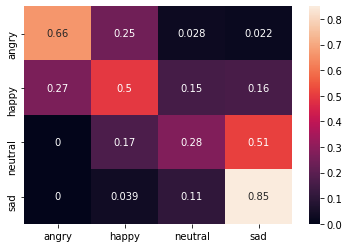

In [ ]:
#test set
p3.load_weights('CREMA//models//paper_3_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.5341991067884377
Kappa: 0.39043376563396226
Accuracy: 0.545578231292517
Jaccard Score: 0.37225116425336946
Precision: 0.5649930580237351
Recall: 0.5423884859936865
              precision    recall  f1-score   support

           0       0.75      0.47      0.58       176
           1       0.46      0.60      0.52       204
           2       0.46      0.30      0.37       176
           3       0.58      0.80      0.67       179

    accuracy                           0.55       735
   macro avg       0.56      0.54      0.53       735
weighted avg       0.56      0.55      0.53       735



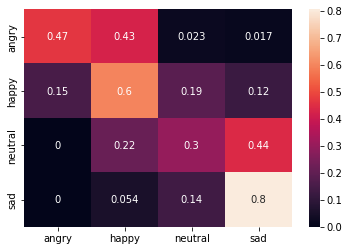

In [ ]:
#test set
p3.load_weights('CREMA//models//paper_3_loss.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 3

In [ ]:
p3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_3_loss_3.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_3_acc_3.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p3.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - ETA: 0s - loss: 1.1608 - accuracy: 0.4606
Epoch 1: val_loss improved from inf to 1.04325, saving model to CREMA//models/paper_3_loss_3.h5

Epoch 1: val_accuracy improved from -inf to 0.51293, saving model to CREMA//models/paper_3_acc_3.h5
429/429 [==============================] - 32s 63ms/step - loss: 1.1608 - accuracy: 0.4606 - val_loss: 1.0432 - val_accuracy: 0.5129
Epoch 2/30
428/429 [============================>.] - ETA: 0s - loss: 1.0670 - accuracy: 0.5018
Epoch 2: val_loss improved from 1.04325 to 0.97987, saving model to CREMA//models/paper_3_loss_3.h5

Epoch 2: val_accuracy improved from 0.51293 to 0.60000, saving model to CREMA//models/paper_3_acc_3.h5
429/429 [==============================] - 27s 64ms/step - loss: 1.0672 - accuracy: 0.5020 - val_loss: 0.9799 - val_accuracy: 0.6000
Epoch 3/30
428/429 [============================>.] - ETA: 0s - loss: 2.6620 - accuracy: 0.5155
Epoch 3: val_loss did not improve from 0.9798

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.53561005364739
Kappa: 0.40689713213562584
Accuracy: 0.5564625850340136
Jaccard Score: 0.3810967096723569
Precision: 0.5497871685135972
Recall: 0.5571900611438074
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       176
           1       0.48      0.51      0.49       204
           2       0.46      0.22      0.29       176
           3       0.55      0.82      0.66       179

    accuracy                           0.56       735
   macro avg       0.55      0.56      0.54       735
weighted avg       0.55      0.56      0.53       735



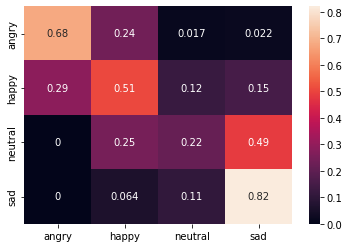

In [ ]:
#test set
p3.load_weights('CREMA//models//paper_3_loss_3.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


F1 SCORE: 0.5543780282486602
Kappa: 0.4259543946891019
Accuracy: 0.5700680272108843
Jaccard Score: 0.3951475120085973
Precision: 0.5681924132353088
Recall: 0.5718604671426721
              precision    recall  f1-score   support

           0       0.71      0.66      0.69       176
           1       0.52      0.50      0.51       204
           2       0.49      0.28      0.36       176
           3       0.55      0.85      0.67       179

    accuracy                           0.57       735
   macro avg       0.57      0.57      0.55       735
weighted avg       0.57      0.57      0.55       735



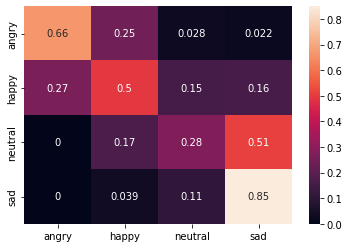

In [ ]:
#test set
p3.load_weights('CREMA//models//paper_3_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# paper 4

In [ ]:
!pip install Signal_Analysis

     |████████████████████████████████| 378 kB 20.2 MB/s 
  Created wheel for Signal-Analysis: filename=Signal_Analysis-0.1.26-py3-none-any.whl size=14531 sha256=4ac6d450617ce80e1ce536d1a91971b1a5ba3cc5457ff05ef9954ab454b090a5
  Stored in directory: /root/.cache/pip/wheels/72/da/25/128af0db67fe61f8282e790d94387346357c063d72522661d6
Successfully built Signal-Analysis


In [ ]:
import numpy as np
import pandas as pd

import ast
import os
from tqdm.notebook import tqdm
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sound Processing
import librosa
from Signal_Analysis.features.signal import get_F_0, get_HNR

# Training Data Preparation
from sklearn.model_selection import train_test_split



import tensorflow as tf
#from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
import numpy as np
import librosa.display
import IPython.display as ipd

In [ ]:
NUM_EMOTIONS = 4
N_FFT = 4096
HOP_LENGTH = 1024
EMOTIONS = ['ang', 'hap', 'neu', 'sad']
SR = 16000


def extract_HSF(lld):
    mean_val = lld.mean()
    min_val = lld.min()
    max_val = lld.max()
    var_val = lld.var()
    range_val = np.subtract(max_val, min_val)
    q25_val = np.quantile(lld, 0.25)
    q50_val = np.quantile(lld, 0.5)
    q75_val = np.quantile(lld, 0.75)
    return np.asarray([
        mean_val,
        min_val,
        max_val,
        var_val,
        range_val,
        q25_val,
        q50_val,
        q75_val,
    ])

def extract_LLD_from_subaudio(subaudio, fs):
    # Frame-wise energy
    energy_val = np.sum(np.square(subaudio)) / (subaudio.shape[0] / fs + 0.00000000000001)
    
    # Frame-wise Zero Crossing Rate
    zcr_val = np.sum((subaudio[:-1] * subaudio[1:]) < 0)
    
    return np.asarray([
        energy_val,
        zcr_val,
    ])

def extract_LLD_from_audio(audio, fs):
    # MFCC
    mfcc = librosa.feature.mfcc(audio, fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False).transpose()
    mfcc_hsf = extract_HSF(mfcc)
    
    # LPC
    lpc = librosa.lpc(audio, 16)
    
    # Mel-Spectrogram
    spect = librosa.feature.melspectrogram(y = audio, sr = fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False)
    spect = librosa.power_to_db(spect, ref = np.max).transpose()
    spect_hsf = extract_HSF(spect)
    
    # Other features
    f0 = get_F_0(audio, fs)[0]
    hnr = get_HNR(audio, fs)
    
    return np.asarray(mfcc), np.asarray(mfcc_hsf), np.asarray(lpc), np.asarray(spect), np.asarray(spect_hsf), np.asarray([f0, hnr])

def extract_LLD(audio, fs):
    #print(audio.shape)
    #print(int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1)
    num_windows = int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1
    framewise_lld = np.zeros((num_windows, 2))
    for idx in range(num_windows):
        subaudio = audio[int(idx * HOP_LENGTH): int(idx * HOP_LENGTH + N_FFT)]
        framewise_lld[idx, :] = extract_LLD_from_subaudio(subaudio, fs)
    framewise_lld_hsf = extract_HSF(framewise_lld)
    
    mfcc, mfcc_hsf, lpc, spect, spect_hsf, others = extract_LLD_from_audio(audio, fs)
    
    assert(framewise_lld.shape[0] == mfcc.shape[0])
    assert(mfcc.shape[0] == spect.shape[0])

    rnn_feats = np.concatenate((framewise_lld, mfcc, spect), axis = 1)
    dense_feats = np.concatenate((framewise_lld_hsf, mfcc_hsf, lpc, spect_hsf, others))
    return rnn_feats, dense_feats

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,3*SR)
    try :
      rnn_feats, dense_feats = extract_LLD(y, SR)
      X.append(rnn_feats)
      Y.append(label_to_onehot(row['labels']))
    except:
      print("Error",row['path'])
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Streaming output truncated to the last 5000 lines.

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:
def RNNSpeechModel(no_of_classes, input_size):
  
  # x = tf.keras.layers.Input((input_len,))
  # x = tf.keras.layers.Reshape((1,-1))(x)
  # m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
  #                      padding='same', sr=sr, n_mels=80,
  #                      fmin=40.0, fmax=sr / 2, power_melgram=1.0,
  #                      return_decibel_melgram=True, trainable_fb=False,
  #                      trainable_kernel=False,
  #                      name='mel_stft')
  # m.trainable = False
  # x = m(x)
  #x = Normalization2D(int_axis=0)(x)
  #x = tf.keras.layers.Permute((2,1,3))(x)

  input = tf.keras.layers.Input((input_size))
  #Bidirectional RNN
  x = tf.keras.layers.Conv2D(10,(5,1),activation='relu',padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(1,(5,1),activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)
  #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)

  #Attention unit
  xFirst = tf.keras.layers.Lambda(lambda q: q[:,-1])(x)
  query = tf.keras.layers.Dense(128)(xFirst)
  att_score = tf.keras.layers.Dot(axes=[1,2])([query,x])
  att_score = tf.keras.layers.Softmax()(att_score)

  #weighted pooling
  att_vector = tf.keras.layers.Dot(axes=[1,1])([att_score,x])
  #x = tf.keras.layers.Dense(64,activation='relu')(att_vector)
  #x = tf.keras.layers.Dense(32,activation='relu')(x)
  output = tf.keras.layers.Dense(no_of_classes,activation='softmax')(att_vector)

  model = tf.keras.models.Model(inputs = input,outputs = output)
  return model
  
no_of_classes = 4
input_size = X_train[0].shape
p4 = RNNSpeechModel(no_of_classes,input_size)
p4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
p4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 43, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 43, 150, 10)  60          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 43, 150, 10)  40         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Trial 1

In [ ]:
# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_4_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_4_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
p4.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - 12s 29ms/step - loss: 0.9332 - acc: 0.5844 - val_loss: 0.8985 - val_acc: 0.5918

Epoch 00001: val_loss improved from inf to 0.89845, saving model to CREMA//models/paper_4_loss.h5
Epoch 2/30
429/429 [==============================] - 11s 26ms/step - loss: 0.8226 - acc: 0.6524 - val_loss: 0.7846 - val_acc: 0.6721

Epoch 00002: val_loss improved from 0.89845 to 0.78457, saving model to CREMA//models/paper_4_loss.h5
Epoch 3/30
429/429 [==============================] - 11s 26ms/step - loss: 0.7851 - acc: 0.6728 - val_loss: 0.8315 - val_acc: 0.6435

Epoch 00003: val_loss did not improve from 0.78457
Epoch 4/30
429/429 [==============================] - 11s 26ms/step - loss: 0.7379 - acc: 0.6993 - val_loss: 0.7688 - val_acc: 0.6844

Epoch 00004: val_loss improved from 0.78457 to 0.76882, saving model to CREMA//models/paper_4_loss.h5
Epoch 5/30
429/429 [==============================] - 11s 26ms/step - loss: 0.6992 - acc: 0.7174 - val_loss

In [ ]:
p4.evaluate(X_test,Y_test)



23/23 [==============================] - 0s 14ms/step - loss: 1.2898 - acc: 0.7020


[1.2898210287094116, 0.7020407915115356]

F1 SCORE: 0.7018050691919594
Kappa: 0.6031219642091041
Accuracy: 0.7020408163265306
Jaccard Score: 0.5418064574314574
Precision: 0.7025500320821616
Recall: 0.7061975945787152
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       176
           1       0.72      0.59      0.65       204
           2       0.69      0.69      0.69       176
           3       0.72      0.74      0.73       179

    accuracy                           0.70       735
   macro avg       0.70      0.71      0.70       735
weighted avg       0.70      0.70      0.70       735



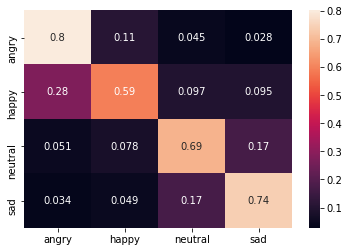

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 2

In [ ]:
# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_4_loss_2.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_4_acc_2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
p4.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - ETA: 0s - loss: 0.9497 - acc: 0.5932
Epoch 1: val_loss improved from inf to 0.91797, saving model to CREMA//models/paper_4_loss_2.h5
429/429 [==============================] - 28s 25ms/step - loss: 0.9497 - acc: 0.5932 - val_loss: 0.9180 - val_acc: 0.6027
Epoch 2/30
427/429 [============================>.] - ETA: 0s - loss: 0.8045 - acc: 0.6742
Epoch 2: val_loss improved from 0.91797 to 0.87862, saving model to CREMA//models/paper_4_loss_2.h5
429/429 [==============================] - 8s 19ms/step - loss: 0.8033 - acc: 0.6745 - val_loss: 0.8786 - val_acc: 0.6422
Epoch 3/30
429/429 [==============================] - ETA: 0s - loss: 0.7212 - acc: 0.7127
Epoch 3: val_loss improved from 0.87862 to 0.82424, saving model to CREMA//models/paper_4_loss_2.h5
429/429 [==============================] - 9s 21ms/step - loss: 0.7212 - acc: 0.7127 - val_loss: 0.8242 - val_acc: 0.6667
Epoch 4/30
425/429 [============================>.] - ETA: 0s - 

In [ ]:
p4.evaluate(X_test,Y_test)



23/23 [==============================] - 0s 8ms/step - loss: 1.4939 - acc: 0.6939


[1.4939324855804443, 0.6938775777816772]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


F1 SCORE: 0.6888122102828284
Kappa: 0.5932244663031206
Accuracy: 0.6938775510204082
Jaccard Score: 0.5282539859208384
Precision: 0.7046206134059215
Recall: 0.7007319020802836
              precision    recall  f1-score   support

           0       0.69      0.84      0.75       176
           1       0.80      0.50      0.62       204
           2       0.68      0.61      0.65       176
           3       0.65      0.85      0.74       179

    accuracy                           0.69       735
   macro avg       0.70      0.70      0.69       735
weighted avg       0.71      0.69      0.69       735



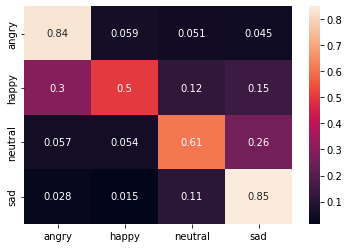

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

#Trial 3

In [ ]:
p4.load_weights('CREMA//models//paper_4_loss_2.h5')

23/23 [==============================] - 0s 7ms/step - loss: 0.8088 - acc: 0.6884


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


F1 SCORE: 0.6905788842801951
Kappa: 0.5834117099635672
Accuracy: 0.6884353741496598
Jaccard Score: 0.5293744006501636
Precision: 0.6947655591957062
Recall: 0.6887545870303429
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       176
           1       0.61      0.67      0.64       204
           2       0.67      0.64      0.65       176
           3       0.74      0.77      0.75       179

    accuracy                           0.69       735
   macro avg       0.69      0.69      0.69       735
weighted avg       0.69      0.69      0.69       735



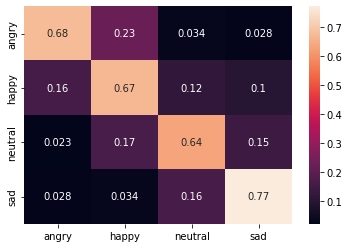

In [ ]:
#test set
from sklearn.metrics import *
p4.evaluate(X_test,Y_test)
cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Paper 5

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_mel_spectrogram(df,max_x = 64,max_y = 501):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path'] 
      y, sr = librosa.core.load(filename,sr = 16000)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      spect = librosa.power_to_db(spect, ref=np.max)
 
      if spect.shape[1] != max_y:
              spect.resize(max_x,max_y, refcheck=False)

      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        #print(q.shape)
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "CREMA//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "CREMA//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "CREMA//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(3430, 14, 64, 64, 3) (3430, 4)
(735, 14, 64, 64, 3) (735, 4)
(735, 14, 64, 64, 3) (735, 4)


In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((14,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

(None, 14, 4096)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 14, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.__operators__.getitem_20 (S  (None, 64, 64, 3)   0           ['input_3[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_21 (S  (None, 64, 64, 3)   0           ['input_3[0][0]']                
 licingOpLambda)                                                           

##trial 1

In [ ]:
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#Fitting our neural network

model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_5_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_5_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p5.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - 151s 265ms/step - loss: 3.2856 - accuracy: 0.4320 - val_loss: 1.1179 - val_accuracy: 0.5088

Epoch 00001: val_loss improved from inf to 1.11786, saving model to CREMA//models/paper_5_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.50884, saving model to CREMA//models/paper_5_acc.h5
Epoch 2/30
429/429 [==============================] - 115s 267ms/step - loss: 1.1132 - accuracy: 0.5198 - val_loss: 1.0096 - val_accuracy: 0.5918

Epoch 00002: val_loss improved from 1.11786 to 1.00961, saving model to CREMA//models/paper_5_loss.h5

Epoch 00002: val_accuracy improved from 0.50884 to 0.59184, saving model to CREMA//models/paper_5_acc.h5
Epoch 3/30
429/429 [==============================] - 115s 267ms/step - loss: 1.0687 - accuracy: 0.5409 - val_loss: 1.3092 - val_accuracy: 0.4082

Epoch 00003: val_loss did not improve from 1.00961

Epoch 00003: val_accuracy did not improve from 0.59184
Epoch 4/30
429/429 [=======================

In [ ]:
p5.load_weights('CREMA//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('CREMA//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

23/23 [==============================] - 39s 195ms/step - loss: 0.9020 - accuracy: 0.6073
[0.8946261405944824, 0.6136054396629333]
23/23 [==============================] - 4s 171ms/step - loss: 0.8671 - accuracy: 0.6231


[0.8671358227729797, 0.6231292486190796]

F1 SCORE: 0.6266470091199773
Kappa: 0.4960582171012735
Accuracy: 0.6231292517006802
Jaccard Score: 0.46206107777921157
Precision: 0.6346619897959184
Recall: 0.6244482493352852
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       176
           1       0.52      0.57      0.55       204
           2       0.54      0.54      0.54       176
           3       0.71      0.78      0.74       179

    accuracy                           0.62       735
   macro avg       0.63      0.62      0.63       735
weighted avg       0.63      0.62      0.62       735



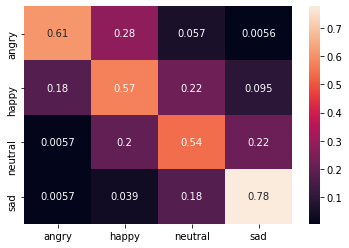

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## trial 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


F1 SCORE: 0.613994235921228
Kappa: 0.485299194192664
Accuracy: 0.6136054421768707
Jaccard Score: 0.45351635564079673
Precision: 0.6116391400558108
Recall: 0.6196455601031677
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       176
           1       0.54      0.45      0.49       204
           2       0.49      0.52      0.51       176
           3       0.74      0.76      0.75       179

    accuracy                           0.61       735
   macro avg       0.61      0.62      0.61       735
weighted avg       0.61      0.61      0.61       735



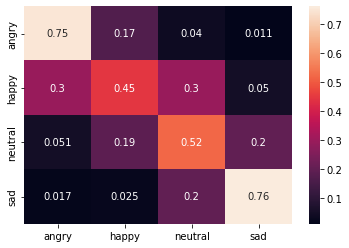

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
p5.load_weights('CREMA//models//paper_5_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

##trial 3

In [ ]:
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#Fitting our neural network

model_checkpoint1 = ModelCheckpoint('CREMA//models//paper_5_loss_3.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//paper_5_acc_3.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p5.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
429/429 [==============================] - ETA: 0s - loss: 1.6048 - accuracy: 0.4761
Epoch 1: val_loss improved from inf to 1.20260, saving model to CREMA//models/paper_5_loss_3.h5

Epoch 1: val_accuracy improved from -inf to 0.43401, saving model to CREMA//models/paper_5_acc_3.h5
429/429 [==============================] - 289s 636ms/step - loss: 1.6048 - accuracy: 0.4761 - val_loss: 1.2026 - val_accuracy: 0.4340
Epoch 2/30
429/429 [==============================] - ETA: 0s - loss: 1.1155 - accuracy: 0.5160
Epoch 2: val_loss did not improve from 1.20260

Epoch 2: val_accuracy improved from 0.43401 to 0.44898, saving model to CREMA//models/paper_5_acc_3.h5
429/429 [==============================] - 269s 627ms/step - loss: 1.1155 - accuracy: 0.5160 - val_loss: 1.2977 - val_accuracy: 0.4490
Epoch 3/30
429/429 [==============================] - ETA: 0s - loss: 1.0608 - accuracy: 0.5318
Epoch 3: val_loss improved from 1.20260 to 1.09568, saving model to CREMA//models/paper_5_loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


F1 SCORE: 0.5238247724615781
Kappa: 0.4304809836433172
Accuracy: 0.5768707482993197
Jaccard Score: 0.38526524891697606
Precision: 0.6036874896273701
Recall: 0.5702176629920633
              precision    recall  f1-score   support

           0       0.78      0.61      0.68       176
           1       0.47      0.71      0.56       204
           2       0.57      0.07      0.13       176
           3       0.60      0.89      0.72       179

    accuracy                           0.58       735
   macro avg       0.60      0.57      0.52       735
weighted avg       0.60      0.58      0.53       735



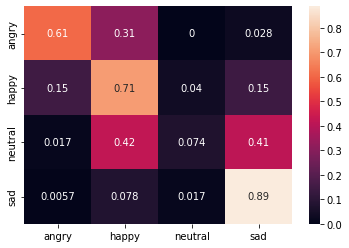

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
#p5.load_weights('CREMA//models//paper_5_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

In [ ]:
p5.save_weights('CREMA//models//paper_5_3.h5')

## Trial 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


F1 SCORE: 0.5833851367755014
Kappa: 0.46267802314083994
Accuracy: 0.5986394557823129
Jaccard Score: 0.4253337794226302
Precision: 0.6045866146265083
Recall: 0.5986703213535287
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       176
           1       0.49      0.57      0.53       204
           2       0.57      0.28      0.38       176
           3       0.62      0.87      0.72       179

    accuracy                           0.60       735
   macro avg       0.60      0.60      0.58       735
weighted avg       0.60      0.60      0.58       735



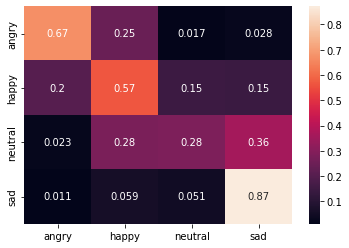

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
p5.load_weights('CREMA//models//paper_5_loss_3.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Trial 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


F1 SCORE: 0.5677876285021967
Kappa: 0.4346767115993334
Accuracy: 0.5755102040816327
Jaccard Score: 0.4104123056220096
Precision: 0.5625985105823477
Recall: 0.5814846729702546
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       176
           1       0.50      0.40      0.45       204
           2       0.43      0.38      0.40       176
           3       0.65      0.79      0.71       179

    accuracy                           0.58       735
   macro avg       0.56      0.58      0.57       735
weighted avg       0.56      0.58      0.56       735



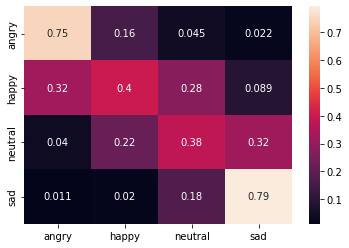

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
p5.load_weights('CREMA//models//paper_5_acc_3.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Jan 2022

## Ensembled

In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

### Testing on Emo db 

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
csvpath = 'EMO_DB/hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 26) (237, 1)
(50, 26) (50, 1)
(51, 26) (51, 1)


In [ ]:
ensembled.load_weights("CREMA//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("CREMA//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 10s 387ms/step - loss: 3.1733 - accuracy: 0.3000
[3.1732892990112305, 0.30000001192092896]
2/2 [==============================] - 0s 97ms/step - loss: 4.9217 - accuracy: 0.2200


[4.921714782714844, 0.2199999988079071]

F1 SCORE: 0.24180868091516805
Kappa: 0.029933481152993324
Accuracy: 0.3
Jaccard Score: 0.14607843137254903
Precision: 0.2165831244778613
Recall: 0.3194805194805195


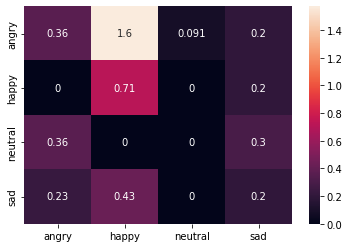

In [ ]:
ensembled.load_weights("CREMA//models/ensembled_loss.h5")
#print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

F1 SCORE: 0.18398268398268397
Kappa: -0.09612141652613837
Accuracy: 0.22
Jaccard Score: 0.10526315789473684
Precision: 0.16363636363636364
Recall: 0.22532467532467532


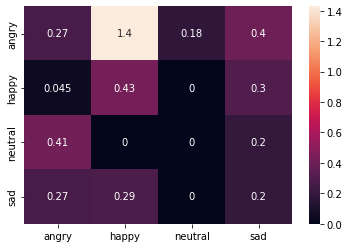

In [ ]:
ensembled.load_weights("CREMA//models/ensembled_acc.h5")
#print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

### Testing on Tess

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:
csvpath = 'TESS/hand_engineered_features_TESS_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)

print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(1114, 26) (1114, 1)
(239, 26) (239, 1)
(239, 26) (239, 1)


In [ ]:
ensembled.load_weights("CREMA//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("CREMA//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

8/8 [==============================] - 2s 186ms/step - loss: 1.6151 - accuracy: 0.4519
[1.6150974035263062, 0.45188283920288086]
8/8 [==============================] - 1s 142ms/step - loss: 1.9459 - accuracy: 0.4310


[1.9458897113800049, 0.43096235394477844]

8/8 [==============================] - 1s 158ms/step - loss: 1.6151 - accuracy: 0.4519
[1.6150974035263062, 0.45188283920288086]
F1 SCORE: 0.4576029797693477
Kappa: 0.26902782966006733
Accuracy: 0.45188284518828453
Jaccard Score: 0.3049704171311866
Precision: 0.5381317434093756
Recall: 0.4484759656196944


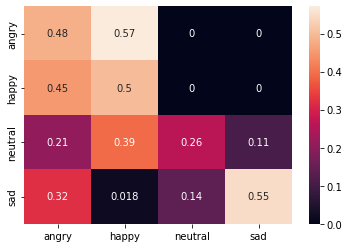

In [ ]:
ensembled.load_weights("CREMA//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

### Testing on Savee (manipulated)

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
csvpath = 'SAVEE/hand_engineered_features_SAVEE_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(207, 26) (207, 1)
(45, 26) (45, 1)
(44, 26) (44, 1)


In [ ]:
#print(ensembled.evaluate([X_test,X_test_features],Y_test))
ensembled.load_weights("EMO_DB//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("EMO_DB//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 360ms/step - loss: 2.1133 - accuracy: 0.4667
[2.11334228515625, 0.46666666865348816]
2/2 [==============================] - 0s 76ms/step - loss: 1.4076 - accuracy: 0.5778


[1.4075660705566406, 0.5777778029441833]

2/2 [==============================] - 0s 108ms/step - loss: 1.4076 - accuracy: 0.5778
[1.4075660705566406, 0.5777778029441833]
F1 SCORE: 0.5727875243664717
Kappa: 0.44444444444444453
Accuracy: 0.5777777777777777
Jaccard Score: 0.4101762820512821
Precision: 0.5944444444444444
Recall: 0.6150793650793651


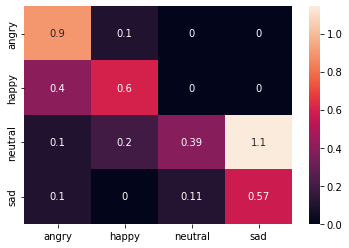

In [ ]:
#test set
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


## Wavenet

In [ ]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(4)] * 2 
sr = 16000
time = 4
# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(int(sr*time), 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))
out = AveragePooling1D(sr*time)(out)
out = Conv1D(8,1,activation='relu')(out)
out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet_paper = Model(history_seq, out)
Wavenet_paper.summary()

Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 16)    32          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 32)    1056        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 64000, 32)    1056        ['conv1d[0][0]']                 
                                                                                              

### Testing on Emo Db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

2/2 [==============================] - 11s 800ms/step - loss: 4.7264 - accuracy: 0.7200
[4.726385116577148, 0.7200000286102295]
2/2 [==============================] - 1s 529ms/step - loss: 4.7264 - accuracy: 0.7200


[4.726385116577148, 0.7200000286102295]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.1527777777777778
Kappa: 0.0
Accuracy: 0.44
Jaccard Score: 0.11
Precision: 0.11
Recall: 0.25
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.44        50
   macro avg       0.11      0.25      0.15        50
weighted avg       0.19      0.44      0.27        50



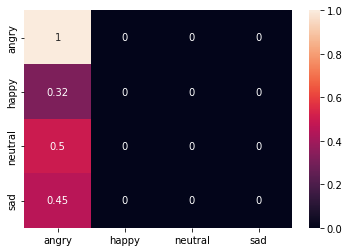

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on TESS

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

8/8 [==============================] - 17s 430ms/step - loss: 1.6117 - accuracy: 0.6820
[1.6116876602172852, 0.6820083856582642]
8/8 [==============================] - 3s 409ms/step - loss: 1.6117 - accuracy: 0.6820


[1.6116876602172852, 0.6820083856582642]

F1 SCORE: 0.23533315607775618
Kappa: -0.01939167929145791
Accuracy: 0.23430962343096234
Jaccard Score: 0.14823429371748698
Precision: 0.247907905803196
Recall: 0.22508545810089742
              precision    recall  f1-score   support

           0       0.52      0.48      0.50        62
           1       0.02      0.04      0.03        56
           2       0.07      0.05      0.06        57
           3       0.38      0.33      0.35        64

    accuracy                           0.23       239
   macro avg       0.25      0.23      0.24       239
weighted avg       0.26      0.23      0.25       239



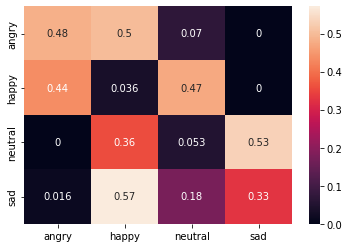

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('CREMA//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

2/2 [==============================] - 1s 315ms/step - loss: 3.3141 - accuracy: 0.6500
[3.314099073410034, 0.6499999761581421]
2/2 [==============================] - 1s 185ms/step - loss: 3.3141 - accuracy: 0.6500


[3.314099073410034, 0.6499999761581421]

F1 SCORE: 0.15975609756097559
Kappa: 0.0006345177664975887
Accuracy: 0.2222222222222222
Jaccard Score: 0.09809027777777778
Precision: 0.15591397849462366
Recall: 0.26071428571428573
              precision    recall  f1-score   support

           0       0.29      0.90      0.44        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        18
           3       0.33      0.14      0.20         7

    accuracy                           0.22        45
   macro avg       0.16      0.26      0.16        45
weighted avg       0.12      0.22      0.13        45



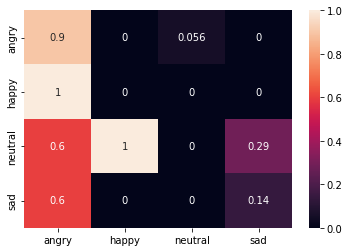

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 1

In [ ]:
time = 4
srk = 16000
def paper_model():
  inp = Input((srk*time,1))
  l1 = BatchNormalization()(Conv1D(32,21,activation='relu',padding = 'same')(inp))
  m1 = MaxPool1D(2)(l1)

  l2 = BatchNormalization()(Conv1D(64,19,activation='relu',padding = 'same')(m1))
  m2 = MaxPool1D(2)(l2)

  l3 = BatchNormalization()(Conv1D(128,17,activation='relu',padding = 'same')(m2))
  m3 = MaxPool1D(2)(l3)


  l4 = BatchNormalization()(Conv1D(256,15,activation='relu',padding = 'same')(m3))
  m4 = MaxPool1D(2)(l4)

  l5 = BatchNormalization()(Conv1D(512,13,activation='relu',padding = 'same')(m4))
  m5 = MaxPool1D(2)(l5)

  l6 = BatchNormalization()(Conv1D(1024,11,activation='relu',padding = 'same')(m5))
  m6 = MaxPool1D(2)(l6)

  l7 = BatchNormalization()(Conv1D(1024,9,activation='relu',padding = 'same')(m6))
  m7 = GlobalMaxPool1D()(l7)

  fl = Flatten()(m7)
  d1 = Dense(128,activation='relu')(fl)
  out = Dense(4,activation='softmax')(d1)

  return Model(inputs = inp,outputs = out)

m = paper_model()
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64000, 1)]        0         
                                                                 
 conv1d_7 (Conv1D)           (None, 64000, 32)         704       
                                                                 
 batch_normalization_7 (Batc  (None, 64000, 32)        128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 32000, 32)        0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 32000, 64)         38976     
                                                                 
 batch_normalization_8 (Batc  (None, 32000, 64)        256 

In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### Testing on Emo db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
srk = 16000
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
m.load_weights('CREMA//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('CREMA//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

2/2 [==============================] - 5s 4s/step - loss: 3.6868 - accuracy: 0.4400
[3.686762809753418, 0.4399999976158142]
2/2 [==============================] - 1s 636ms/step - loss: 3.6868 - accuracy: 0.4400


[3.686762809753418, 0.4399999976158142]

F1 SCORE: 0.1527777777777778
Kappa: 0.0
Accuracy: 0.44
Jaccard Score: 0.11
Precision: 0.11
Recall: 0.25
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.44        50
   macro avg       0.11      0.25      0.15        50
weighted avg       0.19      0.44      0.27        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

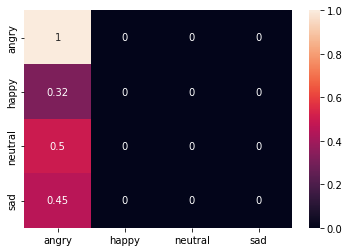

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on TESS

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
srk = 16000
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:
m.load_weights('CREMA//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('CREMA//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

8/8 [==============================] - 9s 1s/step - loss: 1.3052 - accuracy: 0.3556
[1.3052012920379639, 0.35564854741096497]
8/8 [==============================] - 6s 712ms/step - loss: 1.3052 - accuracy: 0.3556


[1.3052012920379639, 0.35564854741096497]

F1 SCORE: 0.3410227910394959
Kappa: 0.1393227948741933
Accuracy: 0.35564853556485354
Jaccard Score: 0.21544153267367552
Precision: 0.33547754811119035
Recall: 0.34903033794162824
              precision    recall  f1-score   support

           0       0.50      0.58      0.54        62
           1       0.13      0.11      0.12        56
           2       0.31      0.33      0.32        57
           3       0.40      0.38      0.39        64

    accuracy                           0.36       239
   macro avg       0.34      0.35      0.34       239
weighted avg       0.34      0.36      0.35       239



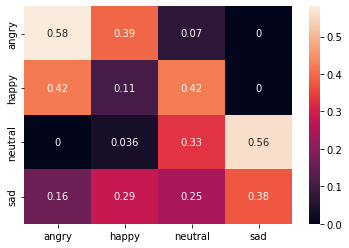

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
srk = 16000
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
m.load_weights('CREMA//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('CREMA//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

2/2 [==============================] - 4s 3s/step - loss: 3.6163 - accuracy: 0.2222
[3.616292715072632, 0.2222222238779068]
2/2 [==============================] - 1s 554ms/step - loss: 3.6163 - accuracy: 0.2222


[3.616292715072632, 0.2222222238779068]

F1 SCORE: 0.16842105263157897
Kappa: 0.0006345177664975887
Accuracy: 0.2222222222222222
Jaccard Score: 0.1053639846743295
Precision: 0.1636904761904762
Recall: 0.26071428571428573
              precision    recall  f1-score   support

           0       0.32      0.90      0.47        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        18
           3       0.33      0.14      0.20         7

    accuracy                           0.22        45
   macro avg       0.16      0.26      0.17        45
weighted avg       0.12      0.22      0.14        45



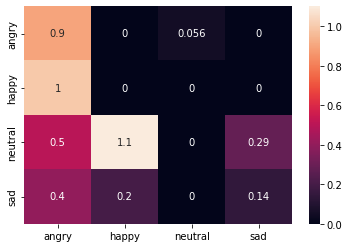

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 2

In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('CREMA/CREMA_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]

max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (64, 501)


In [ ]:
T=80
import keras
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Reshape((36,256))(X)

    X= LSTM(256,return_sequences=True)(X)
    X= LSTM(256)(X)

    
    #X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    #X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    

    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    return model

def paper_2():
    input_layer = Input((int(max_y/T)+1,max_x,T,3))
    alex = AlexNet((227,227,3))
    
    for i in range(int(max_y/T)+1):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      
      cnn = alex(inp)

      #cnn = Reshape((1,4096))(cnn)

      if i == 0:
        output_layers = cnn
      else:
        output_layers = Concatenate(axis = 1)([output_layers,cnn])
      
    
    #print(len(output_layers))
    #lstm = LSTM(256,return_sequences=True)(output_layers)
    #lstm = LSTM(256,return_sequences=True)(lstm)
    #lstm = LSTM(256)(lstm)
    
    out = Dense(4,activation='softmax')(output_layers)
    
    
    
    return Model(inputs=input_layer,outputs=out)
p2 = paper_2()
p2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 7, 64, 80,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 64, 80, 3)   0           ['input_5[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 64, 80, 3)   0           ['input_5[0][0]']                
 icingOpLambda)                                                                             

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### Testing on Emo DB

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(237, 7, 64, 80, 3) (237, 4)
(50, 7, 64, 80, 3) (50, 4)
(51, 7, 64, 80, 3) (51, 4)


In [ ]:
p2.load_weights('CREMA//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('CREMA//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 21s 678ms/step - loss: 1.8172 - accuracy: 0.4600
[1.8172491788864136, 0.46000000834465027]
2/2 [==============================] - 1s 217ms/step - loss: 2.1708 - accuracy: 0.4400


[2.170758008956909, 0.4399999976158142]

F1 SCORE: 0.15714285714285714
Kappa: 0.020979020979020935
Accuracy: 0.44
Jaccard Score: 0.11458333333333333
Precision: 0.11458333333333333
Recall: 0.25
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.44        50
   macro avg       0.11      0.25      0.16        50
weighted avg       0.20      0.44      0.28        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

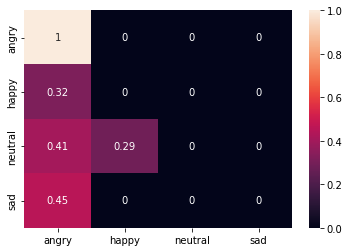

In [ ]:
#test set

from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on TESS

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "TESS//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "TESS//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "TESS//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(1114, 7, 64, 80, 3) (1114, 4)
(239, 7, 64, 80, 3) (239, 4)
(239, 7, 64, 80, 3) (239, 4)


In [ ]:
p2.load_weights('CREMA//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('CREMA//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 3s 321ms/step - loss: 1.6833 - accuracy: 0.3222
[1.6832865476608276, 0.3221757411956787]
8/8 [==============================] - 2s 265ms/step - loss: 1.4442 - accuracy: 0.2720


[1.4441893100738525, 0.27196651697158813]

F1 SCORE: 0.2189594356261023
Kappa: 0.043010010355540196
Accuracy: 0.2719665271966527
Jaccard Score: 0.1327124286620165
Precision: 0.23522286821705427
Recall: 0.2802823591236155
              precision    recall  f1-score   support

           0       0.51      0.35      0.42        62
           1       0.22      0.68      0.33        56
           2       0.21      0.09      0.12        57
           3       0.00      0.00      0.00        64

    accuracy                           0.27       239
   macro avg       0.24      0.28      0.22       239
weighted avg       0.23      0.27      0.22       239



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

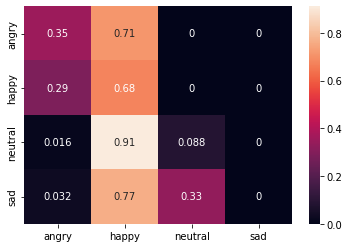

In [ ]:
#test set

from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 7, 64, 80, 3) (207, 4)
(45, 7, 64, 80, 3) (45, 4)
(44, 7, 64, 80, 3) (44, 4)


In [ ]:
p2.load_weights('CREMA//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('CREMA//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 1s 811ms/step - loss: 3.9646 - accuracy: 0.2222
[3.964595317840576, 0.2222222238779068]
2/2 [==============================] - 0s 165ms/step - loss: 4.5362 - accuracy: 0.2222


[4.536207675933838, 0.2222222238779068]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.0909090909090909
Kappa: 0.0
Accuracy: 0.2222222222222222
Jaccard Score: 0.05555555555555555
Precision: 0.05555555555555555
Recall: 0.25
              precision    recall  f1-score   support

           0       0.22      1.00      0.36        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         7

    accuracy                           0.22        45
   macro avg       0.06      0.25      0.09        45
weighted avg       0.05      0.22      0.08        45



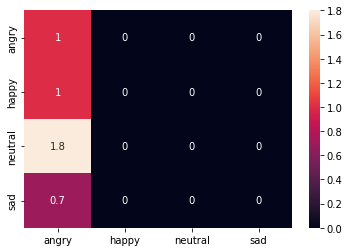

In [ ]:
#test set

from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 3

In [ ]:
def paper_3():
  inp =  Input((time*16000,1))
  l1 = Conv1D(64,80,strides = 4,padding = 'same')(inp)
  m1 = MaxPooling1D(4)(l1)

  l2 = Conv1D(128,3,strides = 1,padding = 'same')(m1)
  l2 = Conv1D(128,3,strides = 1,padding = 'same')(l2)
  m2 = MaxPooling1D(4)(l2)

  l3 = Conv1D(256,3,strides = 1,padding = 'same')(m2)
  l3 = Conv1D(256,3,strides = 1,padding = 'same')(l3)
  m3 = MaxPooling1D(4)(l3)

  l4 = Conv1D(512,3,strides = 1,padding = 'same')(m3)
  l4 = Conv1D(512,3,strides = 1,padding = 'same')(l4)
  m4 = GlobalAveragePooling1D()(l4)

  f1 = Dense(1024)(m4)
  f2 = Dense(4, activation='softmax')(f1)

  return Model(inputs= inp,outputs=f2)

p3 = paper_3()
p3.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64000, 1)]        0         
                                                                 
 conv1d_14 (Conv1D)          (None, 16000, 64)         5184      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 4000, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 4000, 128)         24704     
                                                                 
 conv1d_16 (Conv1D)          (None, 4000, 128)         49280     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1000, 128)        0         
 g1D)                                                      

In [ ]:
p3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

### Testing on Emo DB

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
p3.load_weights('CREMA//models//paper_3_acc.h5')
print(p3.evaluate(X_test,Y_test))
p3.load_weights('CREMA//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

2/2 [==============================] - 2s 325ms/step - loss: 8.0824 - accuracy: 0.4400
[8.08238697052002, 0.4399999976158142]
2/2 [==============================] - 0s 54ms/step - loss: 6.8555 - accuracy: 0.4400


[6.8555402755737305, 0.4399999976158142]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.1527777777777778
Kappa: 0.0
Accuracy: 0.44
Jaccard Score: 0.11
Precision: 0.11
Recall: 0.25
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.44        50
   macro avg       0.11      0.25      0.15        50
weighted avg       0.19      0.44      0.27        50



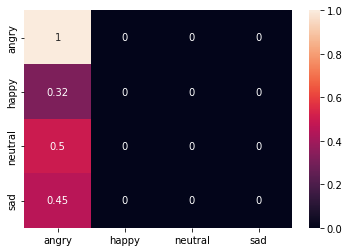

In [ ]:
#test set
p3.load_weights('CREMA//models//paper_3_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on TESS

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:

p3.load_weights('CREMA//models//paper_3_acc.h5')
print(p3.evaluate(X_test,Y_test))
p3.load_weights('CREMA//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

8/8 [==============================] - 1s 113ms/step - loss: 1.2482 - accuracy: 0.3054
[1.2482383251190186, 0.3054393231868744]
8/8 [==============================] - 1s 70ms/step - loss: 1.1287 - accuracy: 0.3640


[1.1286816596984863, 0.36401674151420593]

F1 SCORE: 0.262592881892287
Kappa: 0.06783205281830784
Accuracy: 0.3054393305439331
Jaccard Score: 0.16277946414536404
Precision: 0.266505349743336
Recall: 0.29306854586061926
              precision    recall  f1-score   support

           0       0.38      0.23      0.28        62
           1       0.11      0.09      0.10        56
           2       0.17      0.12      0.14        57
           3       0.41      0.73      0.53        64

    accuracy                           0.31       239
   macro avg       0.27      0.29      0.26       239
weighted avg       0.27      0.31      0.27       239



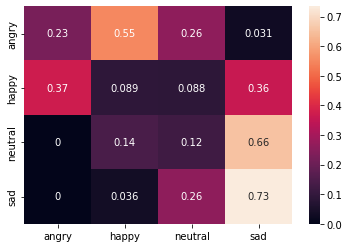

In [ ]:
#test set
p3.load_weights('CREMA//models//paper_3_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
p3.load_weights('CREMA//models//paper_3_acc.h5')
print(p3.evaluate(X_test,Y_test))
p3.load_weights('CREMA//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 329ms/step - loss: 3.2921 - accuracy: 0.2667
[3.2921087741851807, 0.2666666805744171]
2/2 [==============================] - 0s 46ms/step - loss: 2.7218 - accuracy: 0.2889


[2.721754550933838, 0.2888889014720917]

F1 SCORE: 0.20705128205128204
Kappa: 0.05654383735705204
Accuracy: 0.26666666666666666
Jaccard Score: 0.1255050505050505
Precision: 0.3775862068965517
Recall: 0.28849206349206347
              precision    recall  f1-score   support

           0       0.31      0.90      0.46        10
           1       0.00      0.00      0.00        10
           2       1.00      0.11      0.20        18
           3       0.20      0.14      0.17         7

    accuracy                           0.27        45
   macro avg       0.38      0.29      0.21        45
weighted avg       0.50      0.27      0.21        45



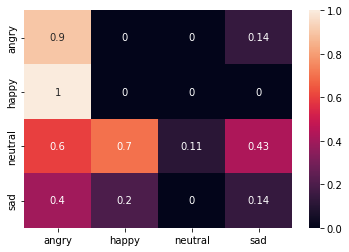

In [ ]:
#test set
p3.load_weights('CREMA//models//paper_3_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 4

In [ ]:
! pip install Signal_Analysis kapre
import numpy as np
import pandas as pd

import ast
import os
from tqdm.notebook import tqdm
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sound Processing
import librosa
from Signal_Analysis.features.signal import get_F_0, get_HNR

# Training Data Preparation
from sklearn.model_selection import train_test_split



import tensorflow as tf
#from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
import numpy as np
import librosa.display
import IPython.display as ipd

In [ ]:
NUM_EMOTIONS = 4
N_FFT = 4096
HOP_LENGTH = 1024
EMOTIONS = ['ang', 'hap', 'neu', 'sad']
SR = 16000


def extract_HSF(lld):
    mean_val = lld.mean()
    min_val = lld.min()
    max_val = lld.max()
    var_val = lld.var()
    range_val = np.subtract(max_val, min_val)
    q25_val = np.quantile(lld, 0.25)
    q50_val = np.quantile(lld, 0.5)
    q75_val = np.quantile(lld, 0.75)
    return np.asarray([
        mean_val,
        min_val,
        max_val,
        var_val,
        range_val,
        q25_val,
        q50_val,
        q75_val,
    ])

def extract_LLD_from_subaudio(subaudio, fs):
    # Frame-wise energy
    energy_val = np.sum(np.square(subaudio)) / (subaudio.shape[0] / fs + 0.00000000000001)
    
    # Frame-wise Zero Crossing Rate
    zcr_val = np.sum((subaudio[:-1] * subaudio[1:]) < 0)
    
    return np.asarray([
        energy_val,
        zcr_val,
    ])

def extract_LLD_from_audio(audio, fs):
    # MFCC
    mfcc = librosa.feature.mfcc(audio, fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False).transpose()
    mfcc_hsf = extract_HSF(mfcc)
    
    # LPC
    lpc = librosa.lpc(audio, 16)
    
    # Mel-Spectrogram
    spect = librosa.feature.melspectrogram(y = audio, sr = fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False)
    spect = librosa.power_to_db(spect, ref = np.max).transpose()
    spect_hsf = extract_HSF(spect)
    
    # Other features
    f0 = get_F_0(audio, fs)[0]
    hnr = get_HNR(audio, fs)
    
    return np.asarray(mfcc), np.asarray(mfcc_hsf), np.asarray(lpc), np.asarray(spect), np.asarray(spect_hsf), np.asarray([f0, hnr])

def extract_LLD(audio, fs):
    #print(audio.shape)
    #print(int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1)
    num_windows = int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1
    framewise_lld = np.zeros((num_windows, 2))
    for idx in range(num_windows):
        subaudio = audio[int(idx * HOP_LENGTH): int(idx * HOP_LENGTH + N_FFT)]
        framewise_lld[idx, :] = extract_LLD_from_subaudio(subaudio, fs)
    framewise_lld_hsf = extract_HSF(framewise_lld)
    
    mfcc, mfcc_hsf, lpc, spect, spect_hsf, others = extract_LLD_from_audio(audio, fs)
    
    assert(framewise_lld.shape[0] == mfcc.shape[0])
    assert(mfcc.shape[0] == spect.shape[0])

    rnn_feats = np.concatenate((framewise_lld, mfcc, spect), axis = 1)
    dense_feats = np.concatenate((framewise_lld_hsf, mfcc_hsf, lpc, spect_hsf, others))
    return rnn_feats, dense_feats

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,3*SR)
    try :
      rnn_feats, dense_feats = extract_LLD(y, SR)
      X.append(rnn_feats)
      Y.append(label_to_onehot(row['labels']))
    except:
      print("Error",row['path'])
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Streaming output truncated to the last 5000 lines.

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:

def RNNSpeechModel(no_of_classes, input_size):
  
  # x = tf.keras.layers.Input((input_len,))
  # x = tf.keras.layers.Reshape((1,-1))(x)
  # m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
  #                      padding='same', sr=sr, n_mels=80,
  #                      fmin=40.0, fmax=sr / 2, power_melgram=1.0,
  #                      return_decibel_melgram=True, trainable_fb=False,
  #                      trainable_kernel=False,
  #                      name='mel_stft')
  # m.trainable = False
  # x = m(x)
  #x = Normalization2D(int_axis=0)(x)
  #x = tf.keras.layers.Permute((2,1,3))(x)

  input = tf.keras.layers.Input((input_size))
  #Bidirectional RNN
  x = tf.keras.layers.Conv2D(10,(5,1),activation='relu',padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(1,(5,1),activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)
  #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)

  #Attention unit
  xFirst = tf.keras.layers.Lambda(lambda q: q[:,-1])(x)
  query = tf.keras.layers.Dense(128)(xFirst)
  att_score = tf.keras.layers.Dot(axes=[1,2])([query,x])
  att_score = tf.keras.layers.Softmax()(att_score)

  #weighted pooling
  att_vector = tf.keras.layers.Dot(axes=[1,1])([att_score,x])
  #x = tf.keras.layers.Dense(64,activation='relu')(att_vector)
  #x = tf.keras.layers.Dense(32,activation='relu')(x)
  output = tf.keras.layers.Dense(no_of_classes,activation='softmax')(att_vector)

  model = tf.keras.models.Model(inputs = input,outputs = output)
  return model
  
no_of_classes = 4
input_size = X_train[0].shape
p4 = RNNSpeechModel(no_of_classes,input_size)
p4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
p4.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 43, 150, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 43, 150, 10)  60          ['input_17[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 43, 150, 10)  40         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                           

### Testing on Emo db

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,3*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:
p4.load_weights('CREMA//models//paper_4_loss.h5')
p4.evaluate(X_test,Y_test)

2/2 [==============================] - 4s 72ms/step - loss: 2.6801 - acc: 0.4000


[2.68009877204895, 0.4000000059604645]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.22533206831119543
Kappa: 0.032258064516129004
Accuracy: 0.4
Jaccard Score: 0.14801587301587302
Precision: 0.18125
Recall: 0.3003246753246753
              precision    recall  f1-score   support

           0       0.42      0.77      0.55        22
           1       0.30      0.43      0.35         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.40        50
   macro avg       0.18      0.30      0.23        50
weighted avg       0.23      0.40      0.29        50



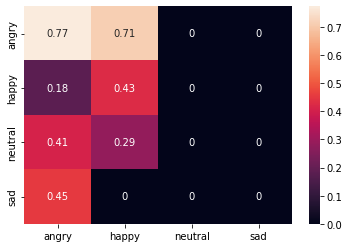

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on TESS

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,3*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:
p4.load_weights('CREMA//models//paper_4_loss.h5')
p4.evaluate(X_test,Y_test)

8/8 [==============================] - 0s 19ms/step - loss: 1.1540 - acc: 0.5063


[1.1540038585662842, 0.5062761306762695]

F1 SCORE: 0.4989379600535414
Kappa: 0.34643461333456926
Accuracy: 0.5062761506276151
Jaccard Score: 0.3411391779238165
Precision: 0.6451109220747241
Recall: 0.5080544102190961
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        62
           1       0.33      0.77      0.46        56
           2       0.59      0.23      0.33        57
           3       1.00      0.38      0.55        64

    accuracy                           0.51       239
   macro avg       0.65      0.51      0.50       239
weighted avg       0.66      0.51      0.50       239



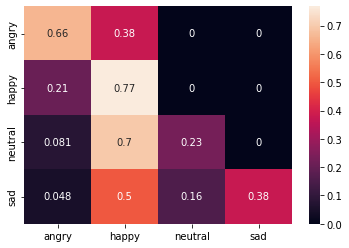

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,3*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:
p4.load_weights('CREMA//models//paper_4_loss.h5')
p4.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 55ms/step - loss: 1.7261 - acc: 0.4667


[1.7261337041854858, 0.46666666865348816]

F1 SCORE: 0.43
Kappa: 0.2931937172774869
Accuracy: 0.4666666666666667
Jaccard Score: 0.2868722050223598
Precision: 0.5059523809523809
Recall: 0.469047619047619
              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.30      0.60      0.40        10
           2       0.86      0.33      0.48        18
           3       0.33      0.14      0.20         7

    accuracy                           0.47        45
   macro avg       0.51      0.47      0.43        45
weighted avg       0.58      0.47      0.45        45



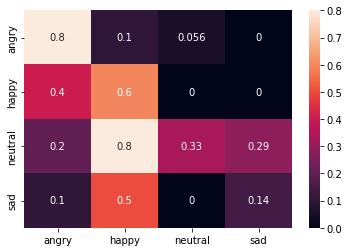

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

## Paper 5

### Testing on emo db

In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((27,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

(None, 27, 4096)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 27, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.__operators__.getitem_53 (S  (None, 64, 64, 3)   0           ['input_9[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_54 (S  (None, 64, 64, 3)   0           ['input_9[0][0]']                
 licingOpLambda)                                                           

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot

def extract_mel_spectrogram(df,max_x = 64,max_y = 898):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))
        z = np.concatenate((q,delta,d_delta),axis = -1)
        s.append(z)

      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
print(X_val_spec.shape,Y_val_spec.shape)

(237, 27, 64, 64, 3) (237, 4)
(50, 27, 64, 64, 3) (50, 4)
(51, 27, 64, 64, 3) (51, 4)


In [ ]:
p5.load_weights('CREMA//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('CREMA//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 22s 1s/step - loss: 1.7967 - accuracy: 0.3000
[1.7966805696487427, 0.30000001192092896]
2/2 [==============================] - 2s 749ms/step - loss: 1.4649 - accuracy: 0.3200


[1.4648714065551758, 0.3199999928474426]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

F1 SCORE: 0.2540322580645161
Kappa: 0.10118130457113506
Accuracy: 0.3
Jaccard Score: 0.15740740740740738
Precision: 0.255718954248366
Recall: 0.3474025974025974
              precision    recall  f1-score   support

           0       0.44      0.18      0.26        22
           1       0.17      0.57      0.26         7
           2       0.41      0.64      0.50        11
           3       0.00      0.00      0.00        10

    accuracy                           0.30        50
   macro avg       0.26      0.35      0.25        50
weighted avg       0.31      0.30      0.26        50



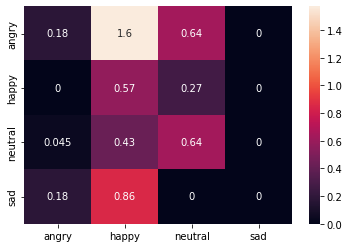

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
p5.load_weights('CREMA//models//paper_5_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on TESS

In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((7,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

(None, 7, 4096)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 7, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_99 (S  (None, 64, 64, 3)   0           ['input_13[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_100 (  (None, 64, 64, 3)   0           ['input_13[0][0]']               
 SlicingOpLambda)                                                          

In [ ]:
def findmaxsize(rslt_df):
    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']
      y, sr = librosa.core.load(filename,sr = 16000)
      
      #print(y.shape)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('TESS/TESS_details.csv',usecols=['labels','path'])
options = ['angry', 'happy','neutral','sad'] 

time = 4
rslt_df = X[X['labels'].isin(options)]

max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (64, 299)


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_mel_spectrogram(df,max_x = max_x,max_y = max_y):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path'] 
      y, sr = librosa.core.load(filename,sr = 16000)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      spect = librosa.power_to_db(spect, ref=np.max)
 
      if spect.shape[1] != max_y:
              spect.resize(max_x,max_y, refcheck=False)

      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        #print(q.shape)
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "TESS//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "TESS//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "TESS//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(1114, 7, 64, 64, 3) (1114, 4)
(239, 7, 64, 64, 3) (239, 4)
(239, 7, 64, 64, 3) (239, 4)


In [ ]:
p5.load_weights('CREMA//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('CREMA//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

8/8 [==============================] - 4s 284ms/step - loss: 6.9245 - accuracy: 0.2594
[6.924523830413818, 0.2594142258167267]
8/8 [==============================] - 2s 222ms/step - loss: 6.6469 - accuracy: 0.2594


[6.646905899047852, 0.2594142258167267]

F1 SCORE: 0.10299003322259137
Kappa: 0.0
Accuracy: 0.2594142259414226
Jaccard Score: 0.06485355648535565
Precision: 0.06485355648535565
Recall: 0.25
              precision    recall  f1-score   support

           0       0.26      1.00      0.41        62
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00        57
           3       0.00      0.00      0.00        64

    accuracy                           0.26       239
   macro avg       0.06      0.25      0.10       239
weighted avg       0.07      0.26      0.11       239



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

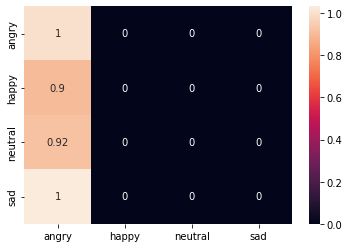

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

### Testing on SAVEE

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}


def label_to_onehot(l):
  #l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_mel_spectrogram(df,max_x = 64,max_y = 714):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path'] 
      y, sr = librosa.core.load(filename,sr = 16000)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      spect = librosa.power_to_db(spect, ref=np.max)
 
      if spect.shape[1] != max_y:
              spect.resize(max_x,max_y, refcheck=False)

      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        #print(q.shape)
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "SAVEE//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "SAVEE//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "SAVEE//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(207, 21, 64, 64, 3) (207, 4)
(45, 21, 64, 64, 3) (45, 4)
(44, 21, 64, 64, 3) (44, 4)


In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]
def div_L1(num):
    a = num // 2
    b = num - a

    return [a, b]
def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((21,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

(None, 21, 4096)
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 21, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 tf.__operators__.getitem_112 (  (None, 64, 64, 3)   0           ['input_15[0][0]']               
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_113 (  (None, 64, 64, 3)   0           ['input_15[0][0]']               
 SlicingOpLambda)                                                         

In [ ]:
p5.load_weights('CREMA//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('CREMA//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 25s 1s/step - loss: 1.4985 - accuracy: 0.4889
[1.498453140258789, 0.4888888895511627]
2/2 [==============================] - 1s 419ms/step - loss: 1.2857 - accuracy: 0.5556


[1.2856919765472412, 0.5555555820465088]

F1 SCORE: 0.43921957671957673
Kappa: 0.3127490039840638
Accuracy: 0.4888888888888889
Jaccard Score: 0.2900159051474841
Precision: 0.6622222222222223
Recall: 0.4718253968253968
              precision    recall  f1-score   support

           0       0.36      0.90      0.51        10
           1       0.40      0.40      0.40        10
           2       0.89      0.44      0.59        18
           3       1.00      0.14      0.25         7

    accuracy                           0.49        45
   macro avg       0.66      0.47      0.44        45
weighted avg       0.68      0.49      0.48        45



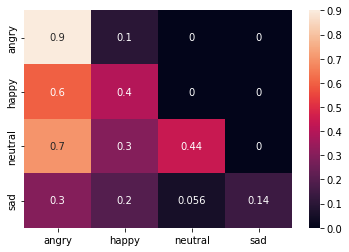

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
p5.load_weights('CREMA//models//paper_5_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Feb 2022

## Hamming Window

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 64000, 1) (3430, 4)
Test Data (735, 64000, 1) (735, 4)
Val Data (735, 64000, 1) (735, 4)


In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 5
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr,window="hamming")
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,window="hamming")
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,window="hamming")
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,window="hamming")
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr,window="hamming")
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "CREMA//train.csv"
test_csv = "CREMA//test.csv"
val_csv = "CREMA//val.csv"
csvpath = 'CREMA//hamming_hand_engineered_features_CREMA_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'CREMA//hamming_hand_engineered_features_CREMA_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'CREMA//hamming_hand_engineered_features_CREMA_val.csv'
extract_features(csvpath,val_csv)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
csvpath = 'CREMA/hamming_hand_engineered_features_CREMA_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'CREMA/hamming_hand_engineered_features_CREMA_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'CREMA/hamming_hand_engineered_features_CREMA_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(3430, 26) (3430, 1)
(735, 26) (735, 1)
(735, 26) (735, 1)


In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 64000, 8)     48          ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 64000, 8)     0           ['conv1d_42[0][0]']              
                                                                                                  
 conv1d_43 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_16[0][0]']         
                                                                                            

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('CREMA//models//ensembled_hamming_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('CREMA//models//ensembled_hamming_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
215/215 [==============================] - ETA: 0s - loss: 0.9654 - accuracy: 0.5633
Epoch 00001: val_loss improved from inf to 0.87418, saving model to CREMA//models/ensembled_hamming_loss.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_accuracy improved from -inf to 0.61224, saving model to CREMA//models/ensembled_hamming_acc.h5
215/215 [==============================] - 28s 120ms/step - loss: 0.9654 - accuracy: 0.5633 - val_loss: 0.8742 - val_accuracy: 0.6122
Epoch 2/30
214/215 [============================>.] - ETA: 0s - loss: 0.8664 - accuracy: 0.6215
Epoch 00002: val_loss improved from 0.87418 to 0.84194, saving model to CREMA//models/ensembled_hamming_loss.h5

Epoch 00002: val_accuracy improved from 0.61224 to 0.63810, saving model to CREMA//models/ensembled_hamming_acc.h5
215/215 [==============================] - 25s 118ms/step - loss: 0.8654 - accuracy: 0.6222 - val_loss: 0.8419 - val_accuracy: 0.6381
Epoch 3/30
214/215 [============================>.] - ETA: 0s - loss: 0.8333 - accuracy: 0.6367
Epoch 00003: val_loss improved from 0.84194 to 0.83653, saving model to CREMA//models/ensembled_hamming_loss.h5

Epoch 00003: val_accuracy did not improve from 0.63810
215/215 [======================

In [ ]:
ensembled.load_weights("CREMA//models/ensembled_hamming_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("CREMA//models/ensembled_hamming_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

23/23 [==============================] - 2s 89ms/step - loss: 0.8003 - accuracy: 0.6408
[0.800286591053009, 0.640816330909729]
23/23 [==============================] - 2s 81ms/step - loss: 0.8011 - accuracy: 0.6558


[0.8010572791099548, 0.6557823419570923]

23/23 [==============================] - 2s 83ms/step - loss: 0.8011 - accuracy: 0.6558
[0.8010572791099548, 0.6557823419570923]
F1 SCORE: 0.657893274633543
Kappa: 0.5413908591383955
Accuracy: 0.6557823129251701
Jaccard Score: 0.4941037595718072
Precision: 0.6597100403955921
Recall: 0.6609694442784732


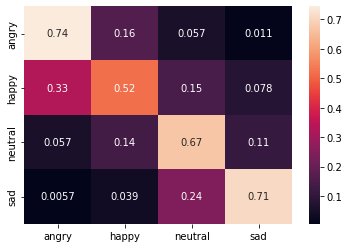

In [ ]:

print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())